In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm_notebook

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, plot_tree 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc , f1_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer , StandardScaler
from sklearn.preprocessing import LabelEncoder



## Read data 

In [40]:
# data train include provider ID and labels
Train = pd.read_csv("data/Train-1542865627584.csv")

# include beneficiary KYC details like health conditions,region
Train_Beneficiarydata = pd.read_csv("data/Train_Beneficiarydata-1542865627584.csv")

# include the claims filed for those patients who are admitted in the hospitals
Train_Inpatientdata=pd.read_csv("data/Train_Inpatientdata-1542865627584.csv")

# include the claims filed for those patients who visit hospitals and not admitted in it.
Train_Outpatientdata=pd.read_csv("data/Train_Outpatientdata-1542865627584.csv")


In [41]:
print("Train\n", Train.shape)
print("Train_Beneficiarydata\n", Train_Beneficiarydata.shape)
print("Train_Inpatientdata\n", Train_Inpatientdata.shape)
print("Train_Outpatientdata\n", Train_Outpatientdata.shape)


Train
 (5410, 2)
Train_Beneficiarydata
 (138556, 25)
Train_Inpatientdata
 (40474, 30)
Train_Outpatientdata
 (517737, 27)


## Functions

In [42]:
def agg_calculation(dataset,
                        groupby_col = '',
                        agg_col = '',
                        sort_col = '',
                        agg_method_lst = [],
                        col_name_lst = []
                       ):
    """This function makes aggregation on specific column"""

    grouped = dataset.groupby(groupby_col)[agg_col].agg(agg_method_lst).reset_index()
    grouped.columns = col_name_lst
    grouped = grouped.sort_values(by = [sort_col], ascending=False).reset_index(drop = True)

    return grouped


In [43]:
# def get_top_5_codes(group, col=''):
#     top_5 = group[col].value_counts().nlargest(5).index.tolist()
#     return top_5

def get_top_5_codes(group, col=''):
    top_5 = group[col].value_counts().nlargest(1).index.tolist()
    return top_5

In [44]:
# Function to count occurrences of values across multiple columns and find top 5
# def top_5_across_columns(df, columns):
#     counts = {}
#     for col in columns:
#         for val in df[col]:
#             if pd.notnull(val):
#                 if val in counts:
#                     counts[val] += 1
#                 else:
#                     counts[val] = 1
#     top_5 = sorted(counts, key=counts.get, reverse=True)[:5]
#     return top_5


def top_5_across_columns(df, columns):
    counts = {}
    for col in columns:
        for val in df[col]:
            if pd.notnull(val):
                if val in counts:
                    counts[val] += 1
                else:
                    counts[val] = 1
    top_5 = sorted(counts, key=counts.get, reverse=True)[:1]
    return top_5

In [45]:
#check for same physician in all three physician columns
def physician_same(row):
    atten_oper = row['AttendingPhysician'] == row['OperatingPhysician']
    oper_other = row['OperatingPhysician'] == row['OtherPhysician']
    atten_other = row['AttendingPhysician'] == row['OtherPhysician']
    
    # atten = oper = other
    if atten_oper == True and oper_other == True:
        return 0
    
    # atten = oper != other
    elif atten_oper == True and oper_other == False:
        return 1
    
    # atten = other != oper
    elif atten_other == True and oper_other == False:
        return 2
    
    # atten != other = oper
    elif atten_other == False and oper_other == True:
        return 3
    
    # atten != other != oper
    else:
        return 4

In [46]:
def get_threshould_fpr_tpr(y, y_pred_prob):
    fpr, tpr, thresholds = roc_curve(y, y_pred_prob)
    return fpr, tpr, thresholds

def draw_Roc_Auc_plot(train_fpr, train_tpr,test_fpr, test_tpr):
    plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="validation AUC = "+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.grid()
    plt.show()

#determining best threshold
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

#pridicting Yq for given Xq with best threshold:
def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def get_confusion_matrix(y, y_pred,axis, best_t):
    cm = pd.DataFrame(confusion_matrix(y, predict_with_best_t(y_pred, best_t)))
    sns.heatmap(cm, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'],ax=axis)

    print(classification_report(y, predict_with_best_t(y_pred, best_t))) 

In [47]:
def model_performence_check(model,X_train,X_test,y_train,y_test):
    
    y_train_pred = model.predict_proba(X_train)[:,1]    
    y_test_pred = model.predict_proba(X_test)[:,1]
    
    train_fpr, train_tpr, tr_thresholds = get_threshould_fpr_tpr(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = get_threshould_fpr_tpr(y_test, y_test_pred)
    
    #plot Roc_AUC_curve
    draw_Roc_Auc_plot(train_fpr, train_tpr,test_fpr, test_tpr)
    
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    #draw confusion matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,3)) 

    #training confusion matrix heatmap
    get_confusion_matrix(y_train, y_train_pred,ax[0], best_t)
    ax[0].set_title("confusion matrix for traning data")

    #test confusion matrix heatmap
    get_confusion_matrix(y_test, y_test_pred,ax[1], best_t)
    ax[1].set_title("confusion matrix for validation data")
    
    actual_output = y_test
    pred_output = predict_with_best_t(y_test_pred, best_t)

    model_accuracy_score = accuracy_score(actual_output,pred_output)
    print("Model validation Accuracy score is : ",model_accuracy_score)
    
    model_recall_score = recall_score(actual_output,pred_output)
    print("Model validation Recall score is : ",model_recall_score)

    model_f1_score = f1_score(actual_output,pred_output)
    print("Model validation F1 score is : ",model_f1_score)
    
    model_AUC_score = auc(test_fpr, test_tpr)
    print("Model validation AUC score is : ",model_AUC_score)
    
    return (model_accuracy_score, model_recall_score, model_f1_score, model_AUC_score)

## Create Features

### Inpatient

In [48]:
print('inpatient columns:\n',  Train_Inpatientdata.columns)
Train_Inpatientdata.head(5)

inpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'AdmissionDt', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'DischargeDt', 'DiagnosisGroupCode',
       'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3',
       'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6',
       'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9',
       'ClmDiagnosisCode_10', 'ClmProcedureCode_1', 'ClmProcedureCode_2',
       'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5',
       'ClmProcedureCode_6'],
      dtype='object')


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [49]:
# check duplicates
print(len(list(Train_Inpatientdata.ClaimID.value_counts()==1)))
print(len(list(Train_Inpatientdata['ClaimID'].unique())))

40474
40474


#### 1. Num of inpatient claims for each provider

In [50]:
df1 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'ClaimID',
                    sort_col = 'ip_claims_num',
                    agg_method_lst = ['count'],
                    col_name_lst = ['Provider', 'ip_claims_num']
                       )
df1

,Provider,ip_claims_num
0,PRV52019,516
1,PRV55462,386
2,PRV54367,322
3,PRV53706,282
4,PRV55209,275
...,...,...
2087,PRV53515,1
2088,PRV53516,1
2089,PRV53600,1
2090,PRV56474,1


#### 2. Num of inpatient patients for each provider

In [51]:
df2 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'BeneID',
                    sort_col = 'ip_patients_num',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'ip_patients_num']
                       )
df_merged = df1.merge(df2, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num
0,PRV52019,516,458
1,PRV55462,386,308
2,PRV54367,322,279
3,PRV53706,282,262
4,PRV55209,275,243
...,...,...,...
2087,PRV53515,1,1
2088,PRV53516,1,1
2089,PRV53600,1,1
2090,PRV56474,1,1


#### 3. Total inpatient reimbursement for each provider

In [52]:
df3 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'InscClaimAmtReimbursed',
                    sort_col = 'ip_reimbursed',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_reimbursed']
                       )
df_merged = df_merged.merge(df3, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num,ip_reimbursed
0,PRV52019,516,458,5580870
1,PRV55462,386,308,4260100
2,PRV54367,322,279,3040900
3,PRV53706,282,262,2776000
4,PRV55209,275,243,2756100
...,...,...,...,...
2087,PRV53515,1,1,14000
2088,PRV53516,1,1,3000
2089,PRV53600,1,1,4000
2090,PRV56474,1,1,7000


#### 4. Total inpatient deductible amount for each provider

In [53]:
df4 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'DeductibleAmtPaid',
                    sort_col = 'ip_deductible',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_deductible']
                       )
df_merged = df_merged.merge(df4, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num,ip_reimbursed,ip_deductible
0,PRV52019,516,458,5580870,536136.0
1,PRV55462,386,308,4260100,405840.0
2,PRV54367,322,279,3040900,334284.0
3,PRV53706,282,262,2776000,296904.0
4,PRV55209,275,243,2756100,289428.0
...,...,...,...,...,...
2087,PRV53515,1,1,14000,1068.0
2088,PRV53516,1,1,3000,1068.0
2089,PRV53600,1,1,4000,1068.0
2090,PRV56474,1,1,7000,1068.0


#### 5. Total claim length for each provider

In [54]:
startdate = pd.to_datetime(Train_Inpatientdata.ClaimStartDt)
enddate = pd.to_datetime(Train_Inpatientdata.ClaimEndDt)
Train_Inpatientdata['Cperiod'] = (enddate - startdate).dt.days+1

df5 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'Cperiod',
                    sort_col = 'ip_cperiod',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_cperiod']
                       )
df_merged = df_merged.merge(df5, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num,ip_reimbursed,ip_deductible,ip_cperiod
0,PRV52019,516,458,5580870,536136.0,3560
1,PRV55462,386,308,4260100,405840.0,2682
2,PRV54367,322,279,3040900,334284.0,2052
3,PRV53706,282,262,2776000,296904.0,1892
4,PRV55209,275,243,2756100,289428.0,1744
...,...,...,...,...,...,...
2087,PRV53515,1,1,14000,1068.0,6
2088,PRV53516,1,1,3000,1068.0,9
2089,PRV53600,1,1,4000,1068.0,3
2090,PRV56474,1,1,7000,1068.0,13


#### 6. Total hospital stay for each provider

In [55]:
startdate = pd.to_datetime(Train_Inpatientdata.AdmissionDt)
enddate = pd.to_datetime(Train_Inpatientdata.DischargeDt)
Train_Inpatientdata['HospitalStay'] = (enddate - startdate).dt.days+1

df6 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'HospitalStay',
                    sort_col = 'ip_hperiod',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'ip_hperiod']
                       )
df_merged = df_merged.merge(df6, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num,ip_reimbursed,ip_deductible,ip_cperiod,ip_hperiod
0,PRV52019,516,458,5580870,536136.0,3560,3568
1,PRV55462,386,308,4260100,405840.0,2682,2682
2,PRV54367,322,279,3040900,334284.0,2052,2052
3,PRV53706,282,262,2776000,296904.0,1892,1919
4,PRV55209,275,243,2756100,289428.0,1744,1744
...,...,...,...,...,...,...,...
2087,PRV53515,1,1,14000,1068.0,6,6
2088,PRV53516,1,1,3000,1068.0,9,9
2089,PRV53600,1,1,4000,1068.0,3,3
2090,PRV56474,1,1,7000,1068.0,13,13


#### 7. Calculate a relationship score among three physcian columns for each claim and average on each provider

In [56]:
Train_Inpatientdata['phy_same'] = Train_Inpatientdata.apply(physician_same, axis=1)

In [57]:
df7 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'phy_same',
                    sort_col = 'ip_phy_same',
                    agg_method_lst = ['mean'],
                    col_name_lst = ['Provider', 'ip_phy_same']
                       )
df_merged = df_merged.merge(df7, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num,ip_reimbursed,ip_deductible,ip_cperiod,ip_hperiod,ip_phy_same
0,PRV52019,516,458,5580870,536136.0,3560,3568,3.614341
1,PRV55462,386,308,4260100,405840.0,2682,2682,4.000000
2,PRV54367,322,279,3040900,334284.0,2052,2052,2.611801
3,PRV53706,282,262,2776000,296904.0,1892,1919,3.659574
4,PRV55209,275,243,2756100,289428.0,1744,1744,2.330909
...,...,...,...,...,...,...,...,...
2087,PRV53515,1,1,14000,1068.0,6,6,4.000000
2088,PRV53516,1,1,3000,1068.0,9,9,4.000000
2089,PRV53600,1,1,4000,1068.0,3,3,1.000000
2090,PRV56474,1,1,7000,1068.0,13,13,4.000000


#### 8. Number of different physicians who appear on a claim and average on each provider

In [58]:
#encoding types of physicians into numeric values
Train_Inpatientdata[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(Train_Inpatientdata[['AttendingPhysician','OperatingPhysician','OtherPhysician']].isnull(), 0, 1)

# number of different physicians who attend a patient
Train_Inpatientdata['N_Types_Physicians'] = Train_Inpatientdata['AttendingPhysician'] +  Train_Inpatientdata['OperatingPhysician'] + Train_Inpatientdata['OtherPhysician']


In [59]:
df8 = agg_calculation(Train_Inpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'N_Types_Physicians',
                    sort_col = 'ip_N_Types_Physicians',
                    agg_method_lst = ['mean'],
                    col_name_lst = ['Provider', 'ip_N_Types_Physicians']
                       )
df_merged = df_merged.merge(df8, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num,ip_reimbursed,ip_deductible,ip_cperiod,ip_hperiod,ip_phy_same,ip_N_Types_Physicians
0,PRV52019,516,458,5580870,536136.0,3560,3568,3.614341,1.812016
1,PRV55462,386,308,4260100,405840.0,2682,2682,4.000000,1.582902
2,PRV54367,322,279,3040900,334284.0,2052,2052,2.611801,1.577640
3,PRV53706,282,262,2776000,296904.0,1892,1919,3.659574,1.723404
4,PRV55209,275,243,2756100,289428.0,1744,1744,2.330909,1.552727
...,...,...,...,...,...,...,...,...,...
2087,PRV53515,1,1,14000,1068.0,6,6,4.000000,2.000000
2088,PRV53516,1,1,3000,1068.0,9,9,4.000000,1.000000
2089,PRV53600,1,1,4000,1068.0,3,3,1.000000,2.000000
2090,PRV56474,1,1,7000,1068.0,13,13,4.000000,1.000000


#### 9. top 5 ClmAdmitDiagnosisCode for each provider

In [60]:
df9 = Train_Inpatientdata.groupby('Provider').apply(lambda x: get_top_5_codes(x, 'ClmAdmitDiagnosisCode')).reset_index(name='Top_5_ClmAdmitDiagnosisCode_ip')
df9

,Provider,Top_5_ClmAdmitDiagnosisCode_ip
0,PRV51001,[29623]
1,PRV51003,[78605]
2,PRV51007,[78097]
3,PRV51008,[7837]
4,PRV51011,[78906]
...,...,...
2087,PRV57719,[68110]
2088,PRV57728,[42789]
2089,PRV57729,[486]
2090,PRV57732,[5119]


In [61]:
df_merged = df_merged.merge(df9, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num,ip_reimbursed,ip_deductible,ip_cperiod,ip_hperiod,ip_phy_same,ip_N_Types_Physicians,Top_5_ClmAdmitDiagnosisCode_ip
0,PRV52019,516,458,5580870,536136.0,3560,3568,3.614341,1.812016,[78650]
1,PRV55462,386,308,4260100,405840.0,2682,2682,4.000000,1.582902,[78650]
2,PRV54367,322,279,3040900,334284.0,2052,2052,2.611801,1.577640,[78650]
3,PRV53706,282,262,2776000,296904.0,1892,1919,3.659574,1.723404,[78605]
4,PRV55209,275,243,2756100,289428.0,1744,1744,2.330909,1.552727,[78650]
...,...,...,...,...,...,...,...,...,...,...
2087,PRV53515,1,1,14000,1068.0,6,6,4.000000,2.000000,[72402]
2088,PRV53516,1,1,3000,1068.0,9,9,4.000000,1.000000,[49322]
2089,PRV53600,1,1,4000,1068.0,3,3,1.000000,2.000000,[V5413]
2090,PRV56474,1,1,7000,1068.0,13,13,4.000000,1.000000,[486]


#### 10. top 5 DiagnosisGroupCode for each provider

In [62]:
df10 = Train_Inpatientdata.groupby('Provider').apply(lambda x: get_top_5_codes(x, 'DiagnosisGroupCode')).reset_index(name='Top_5_DiagnosisGroupCode_ip')
df10

,Provider,Top_5_DiagnosisGroupCode_ip
0,PRV51001,[882]
1,PRV51003,[203]
2,PRV51007,[085]
3,PRV51008,[623]
4,PRV51011,[414]
...,...,...
2087,PRV57719,[605]
2088,PRV57728,[257]
2089,PRV57729,[288]
2090,PRV57732,[941]


In [63]:
df_merged = df_merged.merge(df10, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num,ip_reimbursed,ip_deductible,ip_cperiod,ip_hperiod,ip_phy_same,ip_N_Types_Physicians,Top_5_ClmAdmitDiagnosisCode_ip,Top_5_DiagnosisGroupCode_ip
0,PRV52019,516,458,5580870,536136.0,3560,3568,3.614341,1.812016,[78650],[181]
1,PRV55462,386,308,4260100,405840.0,2682,2682,4.000000,1.582902,[78650],[167]
2,PRV54367,322,279,3040900,334284.0,2052,2052,2.611801,1.577640,[78650],[204]
3,PRV53706,282,262,2776000,296904.0,1892,1919,3.659574,1.723404,[78605],[864]
4,PRV55209,275,243,2756100,289428.0,1744,1744,2.330909,1.552727,[78650],[883]
...,...,...,...,...,...,...,...,...,...,...,...
2087,PRV53515,1,1,14000,1068.0,6,6,4.000000,2.000000,[72402],[476]
2088,PRV53516,1,1,3000,1068.0,9,9,4.000000,1.000000,[49322],[207]
2089,PRV53600,1,1,4000,1068.0,3,3,1.000000,2.000000,[V5413],[514]
2090,PRV56474,1,1,7000,1068.0,13,13,4.000000,1.000000,[486],[188]


#### 11. top 5 ClmDiagnosisCode for each provider

In [64]:
diagnosis_col = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']

df11 = Train_Inpatientdata.groupby('Provider').apply(lambda x: top_5_across_columns(x, diagnosis_col)).reset_index(name='Top_5_ClmDiagnosisCode_ip')
df11

,Provider,Top_5_ClmDiagnosisCode_ip
0,PRV51001,[2724]
1,PRV51003,[4019]
2,PRV51007,[3310]
3,PRV51008,[27651]
4,PRV51011,[5770]
...,...,...
2087,PRV57719,[25000]
2088,PRV57728,[42732]
2089,PRV57729,[4280]
2090,PRV57732,[4019]


In [65]:
df_merged = df_merged.merge(df11, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num,ip_reimbursed,ip_deductible,ip_cperiod,ip_hperiod,ip_phy_same,ip_N_Types_Physicians,Top_5_ClmAdmitDiagnosisCode_ip,Top_5_DiagnosisGroupCode_ip,Top_5_ClmDiagnosisCode_ip
0,PRV52019,516,458,5580870,536136.0,3560,3568,3.614341,1.812016,[78650],[181],[4019]
1,PRV55462,386,308,4260100,405840.0,2682,2682,4.000000,1.582902,[78650],[167],[4019]
2,PRV54367,322,279,3040900,334284.0,2052,2052,2.611801,1.577640,[78650],[204],[4019]
3,PRV53706,282,262,2776000,296904.0,1892,1919,3.659574,1.723404,[78605],[864],[4019]
4,PRV55209,275,243,2756100,289428.0,1744,1744,2.330909,1.552727,[78650],[883],[4019]
...,...,...,...,...,...,...,...,...,...,...,...,...
2087,PRV53515,1,1,14000,1068.0,6,6,4.000000,2.000000,[72402],[476],[72402]
2088,PRV53516,1,1,3000,1068.0,9,9,4.000000,1.000000,[49322],[207],[49322]
2089,PRV53600,1,1,4000,1068.0,3,3,1.000000,2.000000,[V5413],[514],[99666]
2090,PRV56474,1,1,7000,1068.0,13,13,4.000000,1.000000,[486],[188],[486]


#### 12. top 5 ClmProcedureCode for each provider

In [66]:
procedure_col = ['ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3','ClmProcedureCode_4','ClmProcedureCode_5','ClmProcedureCode_6']

df12 = Train_Inpatientdata.groupby('Provider').apply(lambda x: top_5_across_columns(x, procedure_col)).reset_index(name='Top_5_ClmProcedureCode_ip')
df12

,Provider,Top_5_ClmProcedureCode_ip
0,PRV51001,[3521.0]
1,PRV51003,[4019.0]
2,PRV51007,[8627.0]
3,PRV51008,[8954.0]
4,PRV51011,[]
...,...,...
2087,PRV57719,[4516.0]
2088,PRV57728,[]
2089,PRV57729,[3722.0]
2090,PRV57732,[8154.0]


In [67]:
df_merged = df_merged.merge(df12, how = 'outer', on = 'Provider')
df_merged

,Provider,ip_claims_num,ip_patients_num,ip_reimbursed,ip_deductible,ip_cperiod,ip_hperiod,ip_phy_same,ip_N_Types_Physicians,Top_5_ClmAdmitDiagnosisCode_ip,Top_5_DiagnosisGroupCode_ip,Top_5_ClmDiagnosisCode_ip,Top_5_ClmProcedureCode_ip
0,PRV52019,516,458,5580870,536136.0,3560,3568,3.614341,1.812016,[78650],[181],[4019],[4019.0]
1,PRV55462,386,308,4260100,405840.0,2682,2682,4.000000,1.582902,[78650],[167],[4019],[4019.0]
2,PRV54367,322,279,3040900,334284.0,2052,2052,2.611801,1.577640,[78650],[204],[4019],[4019.0]
3,PRV53706,282,262,2776000,296904.0,1892,1919,3.659574,1.723404,[78605],[864],[4019],[4019.0]
4,PRV55209,275,243,2756100,289428.0,1744,1744,2.330909,1.552727,[78650],[883],[4019],[4019.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,PRV53515,1,1,14000,1068.0,6,6,4.000000,2.000000,[72402],[476],[72402],[309.0]
2088,PRV53516,1,1,3000,1068.0,9,9,4.000000,1.000000,[49322],[207],[49322],[]
2089,PRV53600,1,1,4000,1068.0,3,3,1.000000,2.000000,[V5413],[514],[99666],[8944.0]
2090,PRV56474,1,1,7000,1068.0,13,13,4.000000,1.000000,[486],[188],[486],[]


### Outpatient

In [68]:
print('outpatient columns:\n',  Train_Outpatientdata.columns)
Train_Outpatientdata.head(5)

outpatient columns:
 Index(['BeneID', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt', 'Provider',
       'InscClaimAmtReimbursed', 'AttendingPhysician', 'OperatingPhysician',
       'OtherPhysician', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
       'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'ClmProcedureCode_1',
       'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4',
       'ClmProcedureCode_5', 'ClmProcedureCode_6', 'DeductibleAmtPaid',
       'ClmAdmitDiagnosisCode'],
      dtype='object')


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,...,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [69]:
#show null values percentage
print('null value percentage:\n', Train_Outpatientdata.isnull().mean()*100)

null value percentage:
 BeneID                      0.000000
ClaimID                     0.000000
ClaimStartDt                0.000000
ClaimEndDt                  0.000000
Provider                    0.000000
InscClaimAmtReimbursed      0.000000
AttendingPhysician          0.269635
OperatingPhysician         82.497484
OtherPhysician             62.327205
ClmDiagnosisCode_1          2.018979
ClmDiagnosisCode_2         37.737307
ClmDiagnosisCode_3         60.741264
ClmDiagnosisCode_4         75.741351
ClmDiagnosisCode_5         85.640586
ClmDiagnosisCode_6         90.582864
ClmDiagnosisCode_7         93.633640
ClmDiagnosisCode_8         95.574587
ClmDiagnosisCode_9         97.134066
ClmDiagnosisCode_10        99.790820
ClmProcedureCode_1         99.968710
ClmProcedureCode_2         99.993047
ClmProcedureCode_3         99.999227
ClmProcedureCode_4         99.999614
ClmProcedureCode_5        100.000000
ClmProcedureCode_6        100.000000
DeductibleAmtPaid           0.000000
ClmAdmitDiagno

#### 1. Num of outpatient claims for each provider

In [70]:
df13 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'ClaimID',
                    sort_col = 'op_claims_num',
                    agg_method_lst = ['count'],
                    col_name_lst = ['Provider', 'op_claims_num']
                       )
df13

,Provider,op_claims_num
0,PRV51459,8240
1,PRV53797,4739
2,PRV51574,4444
3,PRV53918,3588
4,PRV54895,3433
...,...,...
5007,PRV52754,1
5008,PRV56029,1
5009,PRV52757,1
5010,PRV56050,1


#### 2. Num of outpatient patients for each provider

In [71]:
df14 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'BeneID',
                    sort_col = 'op_patients_num',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'op_patients_num']
                       )
df_merged_op = df13.merge(df14, how = 'outer', on = 'Provider')
df_merged_op

,Provider,op_claims_num,op_patients_num
0,PRV51459,8240,2857
1,PRV53797,4739,2020
2,PRV51574,4444,1715
3,PRV53918,3588,1709
4,PRV54895,3433,1466
...,...,...,...
5007,PRV52754,1,1
5008,PRV56029,1,1
5009,PRV52757,1,1
5010,PRV56050,1,1


#### 3. Total outpatient reimbursement for each provider

In [72]:
df15 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'InscClaimAmtReimbursed',
                    sort_col = 'op_reimbursed',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_reimbursed']
                       )
df_merged_op = df_merged_op.merge(df15, how = 'outer', on = 'Provider')
df_merged_op

,Provider,op_claims_num,op_patients_num,op_reimbursed
0,PRV51459,8240,2857,2321890
1,PRV53797,4739,2020,1303600
2,PRV51574,4444,1715,1281810
3,PRV53918,3588,1709,1014510
4,PRV54895,3433,1466,1004610
...,...,...,...,...
5007,PRV52754,1,1,10
5008,PRV56029,1,1,100
5009,PRV52757,1,1,50
5010,PRV56050,1,1,40


#### 4. Total outpatient deductible amount for each provider

In [73]:
df16 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'DeductibleAmtPaid',
                    sort_col = 'op_deductible',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_deductible']
                       )
df_merged_op = df_merged_op.merge(df16, how = 'outer', on = 'Provider')
df_merged_op

,Provider,op_claims_num,op_patients_num,op_reimbursed,op_deductible
0,PRV51459,8240,2857,2321890,22790
1,PRV53797,4739,2020,1303600,14020
2,PRV51574,4444,1715,1281810,12290
3,PRV53918,3588,1709,1014510,9100
4,PRV54895,3433,1466,1004610,11760
...,...,...,...,...,...
5007,PRV52754,1,1,10,0
5008,PRV56029,1,1,100,0
5009,PRV52757,1,1,50,0
5010,PRV56050,1,1,40,0


#### 5. Total claim length for each provider

In [74]:
startdate = pd.to_datetime(Train_Outpatientdata.ClaimStartDt)
enddate = pd.to_datetime(Train_Outpatientdata.ClaimEndDt)
Train_Outpatientdata['Cperiod'] = (enddate - startdate).dt.days+1

df17 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'Cperiod',
                    sort_col = 'op_cperiod',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'op_cperiod']
                       )
df_merged_op = df_merged_op.merge(df17, how = 'outer', on = 'Provider')
df_merged_op

,Provider,op_claims_num,op_patients_num,op_reimbursed,op_deductible,op_cperiod
0,PRV51459,8240,2857,2321890,22790,19782
1,PRV53797,4739,2020,1303600,14020,10595
2,PRV51574,4444,1715,1281810,12290,10767
3,PRV53918,3588,1709,1014510,9100,8344
4,PRV54895,3433,1466,1004610,11760,8139
...,...,...,...,...,...,...
5007,PRV52754,1,1,10,0,1
5008,PRV56029,1,1,100,0,1
5009,PRV52757,1,1,50,0,1
5010,PRV56050,1,1,40,0,1


#### 6. Calculate a relationship score among three physcian columns for each claim and average on each provider

In [75]:
Train_Outpatientdata['phy_same'] = Train_Outpatientdata.apply(physician_same, axis=1)

In [76]:
df18 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'phy_same',
                    sort_col = 'op_phy_same',
                    agg_method_lst = ['mean'],
                    col_name_lst = ['Provider', 'op_phy_same']
                       )
df_merged_op = df_merged_op.merge(df18, how = 'outer', on = 'Provider')
df_merged_op

,Provider,op_claims_num,op_patients_num,op_reimbursed,op_deductible,op_cperiod,op_phy_same
0,PRV51459,8240,2857,2321890,22790,19782,3.388835
1,PRV53797,4739,2020,1303600,14020,10595,3.241612
2,PRV51574,4444,1715,1281810,12290,10767,3.635464
3,PRV53918,3588,1709,1014510,9100,8344,3.503902
4,PRV54895,3433,1466,1004610,11760,8139,3.768715
...,...,...,...,...,...,...,...
5007,PRV52754,1,1,10,0,1,4.000000
5008,PRV56029,1,1,100,0,1,2.000000
5009,PRV52757,1,1,50,0,1,4.000000
5010,PRV56050,1,1,40,0,1,4.000000


#### 7. Number of different physicians who appear on a claim and average on each provider

In [77]:
#encoding types of physicians into numeric values
Train_Outpatientdata[['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']] = np.where(Train_Outpatientdata[['AttendingPhysician','OperatingPhysician','OtherPhysician']].isnull(), 0, 1)

# number of different physicians who attend a patient
Train_Outpatientdata['N_Types_Physicians'] = Train_Outpatientdata['AttendingPhysician'] +  Train_Outpatientdata['OperatingPhysician'] + Train_Outpatientdata['OtherPhysician']


In [78]:
df19 = agg_calculation(Train_Outpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'N_Types_Physicians',
                    sort_col = 'op_N_Types_Physicians',
                    agg_method_lst = ['mean'],
                    col_name_lst = ['Provider', 'op_N_Types_Physicians']
                       )
df_merged_op = df_merged_op.merge(df19, how = 'outer', on = 'Provider')
df_merged_op

,Provider,op_claims_num,op_patients_num,op_reimbursed,op_deductible,op_cperiod,op_phy_same,op_N_Types_Physicians
0,PRV51459,8240,2857,2321890,22790,19782,3.388835,1.560316
1,PRV53797,4739,2020,1303600,14020,10595,3.241612,1.568052
2,PRV51574,4444,1715,1281810,12290,10767,3.635464,1.568182
3,PRV53918,3588,1709,1014510,9100,8344,3.503902,1.544314
4,PRV54895,3433,1466,1004610,11760,8139,3.768715,1.555491
...,...,...,...,...,...,...,...,...
5007,PRV52754,1,1,10,0,1,4.000000,1.000000
5008,PRV56029,1,1,100,0,1,2.000000,2.000000
5009,PRV52757,1,1,50,0,1,4.000000,1.000000
5010,PRV56050,1,1,40,0,1,4.000000,1.000000


#### 8. top 5 ClmAdmitDiagnosisCode for each provider

In [79]:
df20 = Train_Outpatientdata.groupby('Provider').apply(lambda x: get_top_5_codes(x, 'ClmAdmitDiagnosisCode')).reset_index(name='Top_5_ClmAdmitDiagnosisCode_op')
df20

,Provider,Top_5_ClmAdmitDiagnosisCode_op
0,PRV51001,[59970]
1,PRV51003,[2724]
2,PRV51004,[V7612]
3,PRV51005,[42731]
4,PRV51007,[25000]
...,...,...
5007,PRV57759,[78959]
5008,PRV57760,[7242]
5009,PRV57761,[7295]
5010,PRV57762,[1748]


In [80]:
df_merged_op = df_merged_op.merge(df20, how = 'outer', on = 'Provider')
df_merged_op

,Provider,op_claims_num,op_patients_num,op_reimbursed,op_deductible,op_cperiod,op_phy_same,op_N_Types_Physicians,Top_5_ClmAdmitDiagnosisCode_op
0,PRV51459,8240,2857,2321890,22790,19782,3.388835,1.560316,[V7612]
1,PRV53797,4739,2020,1303600,14020,10595,3.241612,1.568052,[V7612]
2,PRV51574,4444,1715,1281810,12290,10767,3.635464,1.568182,[V7612]
3,PRV53918,3588,1709,1014510,9100,8344,3.503902,1.544314,[V7612]
4,PRV54895,3433,1466,1004610,11760,8139,3.768715,1.555491,[V7612]
...,...,...,...,...,...,...,...,...,...
5007,PRV52754,1,1,10,0,1,4.000000,1.000000,[]
5008,PRV56029,1,1,100,0,1,2.000000,2.000000,[]
5009,PRV52757,1,1,50,0,1,4.000000,1.000000,[]
5010,PRV56050,1,1,40,0,1,4.000000,1.000000,[]


#### 9. top 5 ClmDiagnosisCode for each provider

In [81]:
diagnosis_col = ['ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4','ClmDiagnosisCode_5','ClmDiagnosisCode_6','ClmDiagnosisCode_7','ClmDiagnosisCode_8','ClmDiagnosisCode_9','ClmDiagnosisCode_10']

df21 = Train_Outpatientdata.groupby('Provider').apply(lambda x: top_5_across_columns(x, diagnosis_col)).reset_index(name='Top_5_ClmDiagnosisCode_op')
df21

,Provider,Top_5_ClmDiagnosisCode_op
0,PRV51001,[5168]
1,PRV51003,[V5869]
2,PRV51004,[4019]
3,PRV51005,[4019]
4,PRV51007,[4019]
...,...,...
5007,PRV57759,[V5869]
5008,PRV57760,[4019]
5009,PRV57761,[4019]
5010,PRV57762,[2330]


In [82]:
df_merged_op = df_merged_op.merge(df21, how = 'outer', on = 'Provider')
df_merged_op

,Provider,op_claims_num,op_patients_num,op_reimbursed,op_deductible,op_cperiod,op_phy_same,op_N_Types_Physicians,Top_5_ClmAdmitDiagnosisCode_op,Top_5_ClmDiagnosisCode_op
0,PRV51459,8240,2857,2321890,22790,19782,3.388835,1.560316,[V7612],[4019]
1,PRV53797,4739,2020,1303600,14020,10595,3.241612,1.568052,[V7612],[4019]
2,PRV51574,4444,1715,1281810,12290,10767,3.635464,1.568182,[V7612],[4019]
3,PRV53918,3588,1709,1014510,9100,8344,3.503902,1.544314,[V7612],[4019]
4,PRV54895,3433,1466,1004610,11760,8139,3.768715,1.555491,[V7612],[4019]
...,...,...,...,...,...,...,...,...,...,...
5007,PRV52754,1,1,10,0,1,4.000000,1.000000,[],[2724]
5008,PRV56029,1,1,100,0,1,2.000000,2.000000,[],[4910]
5009,PRV52757,1,1,50,0,1,4.000000,1.000000,[],[]
5010,PRV56050,1,1,40,0,1,4.000000,1.000000,[],[38600]


### Beneficiary

In [83]:
print('inpatient columns:\n',  Train_Beneficiarydata.columns)
Train_Beneficiarydata.head(5)

inpatient columns:
 Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt'],
      dtype='object')


,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,...,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,...,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,...,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,...,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,...,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,...,2,1,2,2,2,2,0,0,1790,1200


In [84]:
Train_Allpatientdata = pd.merge(Train_Outpatientdata, Train_Inpatientdata, how='outer')
Train_Allpatientdata = pd.merge(Train_Allpatientdata, Train_Beneficiarydata, on = 'BeneID', how = 'outer')

#### 1. Num of death cases

In [85]:
Train_Allpatientdata['Is_Dead'] = np.where(Train_Allpatientdata['DOD'].isnull(), 0, 1)

In [86]:
df22 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'Is_Dead',
                    sort_col = 'num_death_cases',
                    agg_method_lst = ['sum'],
                    col_name_lst = ['Provider', 'num_death_cases']
                       )
df22

,Provider,num_death_cases
0,PRV51459,52
1,PRV53918,35
2,PRV53797,35
3,PRV55215,31
4,PRV52064,31
...,...,...
5405,PRV53632,0
5406,PRV53635,0
5407,PRV53638,0
5408,PRV53640,0


#### 2. Average patients' age for each provider

maybe some providers are specialized on specific age disease

In [87]:
#Add column age
# Convert 'DOB' and 'ClaimStartDt' columns to datetime format
Train_Allpatientdata['DOB'] =  pd.to_datetime(Train_Allpatientdata['DOB'], format='%Y-%m-%d')  
Train_Allpatientdata['ClaimStartDt'] = pd.to_datetime(Train_Allpatientdata['ClaimStartDt'], format='%Y-%m-%d')  
Train_Allpatientdata['Age'] = (Train_Allpatientdata['ClaimStartDt'] - Train_Allpatientdata['DOB']).dt.days // 365

In [88]:
unique_bene_per_provider = Train_Allpatientdata.drop_duplicates(subset=['Provider', 'BeneID'])
df23 = agg_calculation(unique_bene_per_provider,
                    groupby_col = 'Provider',
                    agg_col = 'Age',
                    sort_col = 'avg_age',
                    agg_method_lst = ['mean'],
                    col_name_lst = ['Provider', 'avg_age']
                       )
df23

,Provider,avg_age
0,PRV55591,99.0
1,PRV54817,99.0
2,PRV55355,98.0
3,PRV51423,98.0
4,PRV56974,98.0
...,...,...
5405,PRV52816,40.0
5406,PRV53501,40.0
5407,PRV57473,37.0
5408,PRV51236,35.0


In [89]:
df_merged_pt = df22.merge(df23, how = 'outer', on = 'Provider')
df_merged_pt

,Provider,num_death_cases,avg_age
0,PRV51459,52,73.532027
1,PRV53918,35,72.317145
2,PRV53797,35,72.515842
3,PRV55215,31,72.106520
4,PRV52064,31,73.094401
...,...,...,...
5405,PRV53632,0,75.250000
5406,PRV53635,0,69.442308
5407,PRV53638,0,69.907407
5408,PRV53640,0,73.962963


#### 3. Num of different state (location of provider)

In [90]:
df24 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'State',
                    sort_col = 'num_State',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'num_State']
                       )
df24

,Provider,num_State
0,PRV51578,38
1,PRV54070,38
2,PRV52019,36
3,PRV55510,34
4,PRV52154,32
...,...,...
5405,PRV52179,1
5406,PRV52178,1
5407,PRV52176,1
5408,PRV52173,1


In [91]:
df_merged_pt = df_merged_pt.merge(df24, how = 'outer', on = 'Provider')
df_merged_pt

,Provider,num_death_cases,avg_age,num_State
0,PRV51459,52,73.532027,10
1,PRV53918,35,72.317145,5
2,PRV53797,35,72.515842,9
3,PRV55215,31,72.106520,25
4,PRV52064,31,73.094401,28
...,...,...,...,...
5405,PRV53632,0,75.250000,2
5406,PRV53635,0,69.442308,6
5407,PRV53638,0,69.907407,4
5408,PRV53640,0,73.962963,4


#### 4. Num of different county (location of provider)

In [92]:
df25 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'County',
                    sort_col = 'num_County',
                    agg_method_lst = ['nunique'],
                    col_name_lst = ['Provider', 'num_County']
                       )
df25

,Provider,num_County
0,PRV55215,112
1,PRV57173,103
2,PRV54070,96
3,PRV52019,88
4,PRV56444,87
...,...,...
5405,PRV52286,1
5406,PRV52294,1
5407,PRV52296,1
5408,PRV55895,1


In [93]:
df_merged_pt = df_merged_pt.merge(df25, how = 'outer', on = 'Provider')
df_merged_pt

,Provider,num_death_cases,avg_age,num_State,num_County
0,PRV51459,52,73.532027,10,24
1,PRV53918,35,72.317145,5,43
2,PRV53797,35,72.515842,9,25
3,PRV55215,31,72.106520,25,112
4,PRV52064,31,73.094401,28,82
...,...,...,...,...,...
5405,PRV53632,0,75.250000,2,5
5406,PRV53635,0,69.442308,6,12
5407,PRV53638,0,69.907407,4,9
5408,PRV53640,0,73.962963,4,4


#### 5. Average Charlson Comorbidity Index(CCI) of patients for each provider

In [94]:
# Replace values with a CCI score
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                   'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                   'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                   'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2, 'RenalDiseaseIndicator': '0'}, 
                  0)

In [95]:
# CII score calculation
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_KidneyDisease': 1}, 2)
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Cancer': 1}, 4)
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Diabetes': 1}, 1.5)
Train_Allpatientdata = Train_Allpatientdata.replace({'ChronicCond_Osteoporasis': 1}, 2)
Train_Allpatientdata = Train_Allpatientdata.replace({'RenalDiseaseIndicator': 'Y'}, 2)

Train_Allpatientdata['CII_age_score'] = np.where(Train_Allpatientdata['Age'] < 50, 0,
                                                 np.where((Train_Allpatientdata['Age'] >= 50) & (Train_Allpatientdata['Age'] <= 59), 1,
                                                          np.where((Train_Allpatientdata['Age'] >= 60) & (Train_Allpatientdata['Age'] <= 69), 2,
                                                                   np.where((Train_Allpatientdata['Age'] >= 70) & (Train_Allpatientdata['Age'] <= 79), 3,
                                                                            np.where(Train_Allpatientdata['Age'] >= 80, 4, np.nan)))))

In [96]:
cci_column = ['RenalDiseaseIndicator', 'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
            'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
            'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
            'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke', 'CII_age_score']

In [97]:
Train_Allpatientdata['cci_score'] = Train_Allpatientdata[cci_column].sum(axis = 1)

In [98]:
df26 = agg_calculation(Train_Allpatientdata,
                    groupby_col = 'Provider',
                    agg_col = 'cci_score',
                    sort_col = 'avg_cci_score',
                    agg_method_lst = ['mean'],
                    col_name_lst = ['Provider', 'avg_cci_score']
                       )
df26

,Provider,avg_cci_score
0,PRV54054,21.5
1,PRV52791,19.5
2,PRV52952,18.5
3,PRV53083,18.5
4,PRV56084,17.5
...,...,...
5405,PRV52638,2.0
5406,PRV54420,1.5
5407,PRV57467,1.0
5408,PRV51666,0.0


In [99]:
df_merged_pt = df_merged_pt.merge(df26, how = 'outer', on = 'Provider')
df_merged_pt

,Provider,num_death_cases,avg_age,num_State,num_County,avg_cci_score
0,PRV51459,52,73.532027,10,24,9.056189
1,PRV53918,35,72.317145,5,43,8.964744
2,PRV53797,35,72.515842,9,25,8.973096
3,PRV55215,31,72.106520,25,112,9.059387
4,PRV52064,31,73.094401,28,82,9.104782
...,...,...,...,...,...,...
5405,PRV53632,0,75.250000,2,5,11.133333
5406,PRV53635,0,69.442308,6,12,8.564815
5407,PRV53638,0,69.907407,4,9,9.621622
5408,PRV53640,0,73.962963,4,4,8.606061


### Merge

In [100]:
df_final = df_merged_pt.merge(df_merged_op, how = 'outer', on = 'Provider')

In [101]:
df_final = df_final.merge(df_merged, how = 'outer', on = 'Provider')
df_final

,Provider,num_death_cases,avg_age,num_State,num_County,avg_cci_score,op_claims_num,op_patients_num,op_reimbursed,op_deductible,...,ip_reimbursed,ip_deductible,ip_cperiod,ip_hperiod,ip_phy_same,ip_N_Types_Physicians,Top_5_ClmAdmitDiagnosisCode_ip,Top_5_DiagnosisGroupCode_ip,Top_5_ClmDiagnosisCode_ip,Top_5_ClmProcedureCode_ip
0,PRV51459,52,73.532027,10,24,9.056189,8240.0,2857.0,2321890.0,22790.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PRV53918,35,72.317145,5,43,8.964744,3588.0,1709.0,1014510.0,9100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PRV53797,35,72.515842,9,25,8.973096,4739.0,2020.0,1303600.0,14020.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PRV55215,31,72.106520,25,112,9.059387,3250.0,2517.0,927260.0,7670.0,...,1357300.0,151656.0,935.0,935.0,3.846154,1.783217,[486],[344],[4019],[4019.0]
4,PRV52064,31,73.094401,28,82,9.104782,2806.0,1499.0,769680.0,8440.0,...,350000.0,39516.0,223.0,223.0,4.000000,1.710526,[5990],[387],[4019],[3995.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV53632,0,75.250000,2,5,11.133333,13.0,10.0,7380.0,0.0,...,7000.0,2136.0,8.0,8.0,4.000000,1.500000,[99672],[220],[319],[3893.0]
5406,PRV53635,0,69.442308,6,12,8.564815,49.0,47.0,8660.0,200.0,...,82000.0,5340.0,23.0,23.0,1.600000,1.800000,[78906],[356],[4019],[9607.0]
5407,PRV53638,0,69.907407,4,9,9.621622,111.0,54.0,38040.0,140.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5408,PRV53640,0,73.962963,4,4,8.606061,33.0,27.0,5660.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### add labels

In [102]:
df_final = df_final.merge(Train, how = 'inner', on = 'Provider')
df_final

,Provider,num_death_cases,avg_age,num_State,num_County,avg_cci_score,op_claims_num,op_patients_num,op_reimbursed,op_deductible,...,ip_deductible,ip_cperiod,ip_hperiod,ip_phy_same,ip_N_Types_Physicians,Top_5_ClmAdmitDiagnosisCode_ip,Top_5_DiagnosisGroupCode_ip,Top_5_ClmDiagnosisCode_ip,Top_5_ClmProcedureCode_ip,PotentialFraud
0,PRV51459,52,73.532027,10,24,9.056189,8240.0,2857.0,2321890.0,22790.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
1,PRV53918,35,72.317145,5,43,8.964744,3588.0,1709.0,1014510.0,9100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
2,PRV53797,35,72.515842,9,25,8.973096,4739.0,2020.0,1303600.0,14020.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
3,PRV55215,31,72.106520,25,112,9.059387,3250.0,2517.0,927260.0,7670.0,...,151656.0,935.0,935.0,3.846154,1.783217,[486],[344],[4019],[4019.0],Yes
4,PRV52064,31,73.094401,28,82,9.104782,2806.0,1499.0,769680.0,8440.0,...,39516.0,223.0,223.0,4.000000,1.710526,[5990],[387],[4019],[3995.0],Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV53632,0,75.250000,2,5,11.133333,13.0,10.0,7380.0,0.0,...,2136.0,8.0,8.0,4.000000,1.500000,[99672],[220],[319],[3893.0],No
5406,PRV53635,0,69.442308,6,12,8.564815,49.0,47.0,8660.0,200.0,...,5340.0,23.0,23.0,1.600000,1.800000,[78906],[356],[4019],[9607.0],No
5407,PRV53638,0,69.907407,4,9,9.621622,111.0,54.0,38040.0,140.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
5408,PRV53640,0,73.962963,4,4,8.606061,33.0,27.0,5660.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No


In [103]:
df_final['PotentialFraud'] = df_final['PotentialFraud'].map({"Yes":1,"No":0})#.astype('category',copy=False)

In [104]:
print(df_final.PotentialFraud.value_counts())


PotentialFraud
0    4904
1     506
Name: count, dtype: int64


### data preprocessing

#### null values

In [105]:
#null values
df_final.isnull().mean()*100

Provider                           0.000000
num_death_cases                    0.000000
avg_age                            0.000000
num_State                          0.000000
num_County                         0.000000
avg_cci_score                      0.000000
op_claims_num                      7.356747
op_patients_num                    7.356747
op_reimbursed                      7.356747
op_deductible                      7.356747
op_cperiod                         7.356747
op_phy_same                        7.356747
op_N_Types_Physicians              7.356747
Top_5_ClmAdmitDiagnosisCode_op     7.356747
Top_5_ClmDiagnosisCode_op          7.356747
ip_claims_num                     61.330869
ip_patients_num                   61.330869
ip_reimbursed                     61.330869
ip_deductible                     61.330869
ip_cperiod                        61.330869
ip_hperiod                        61.330869
ip_phy_same                       61.330869
ip_N_Types_Physicians           

In [106]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Provider                        5410 non-null   object 
 1   num_death_cases                 5410 non-null   int64  
 2   avg_age                         5410 non-null   float64
 3   num_State                       5410 non-null   int64  
 4   num_County                      5410 non-null   int64  
 5   avg_cci_score                   5410 non-null   float64
 6   op_claims_num                   5012 non-null   float64
 7   op_patients_num                 5012 non-null   float64
 8   op_reimbursed                   5012 non-null   float64
 9   op_deductible                   5012 non-null   float64
 10  op_cperiod                      5012 non-null   float64
 11  op_phy_same                     5012 non-null   float64
 12  op_N_Types_Physicians           50

In [107]:
# numeric columns: replace null with 0
df_final[df_final.select_dtypes(include=['int', 'float']).columns] = df_final.select_dtypes(include=['int', 'float']).fillna(0)

#### EDA for numerical columns

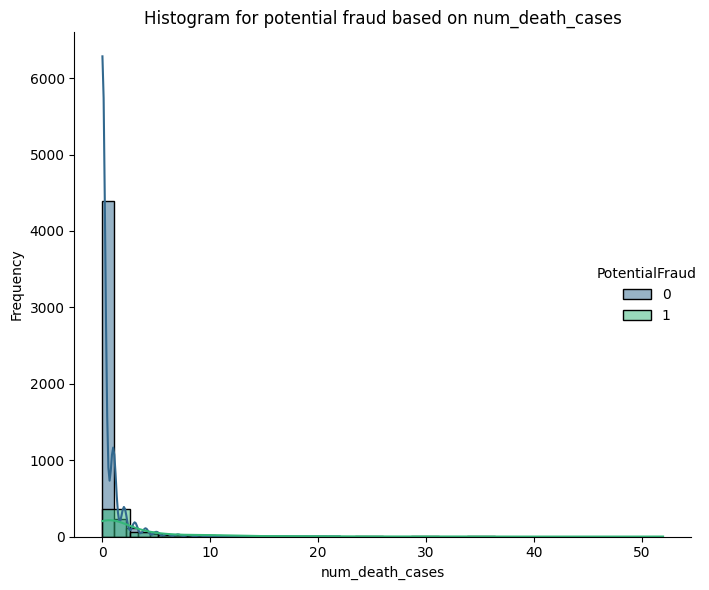

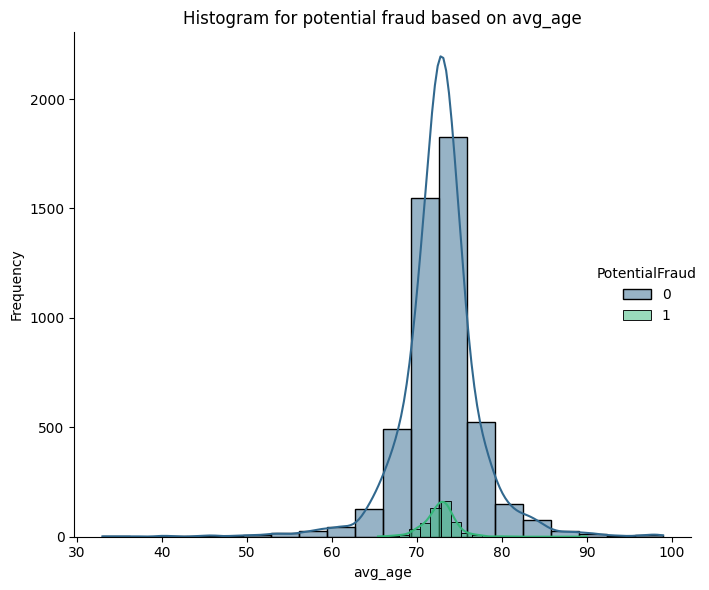

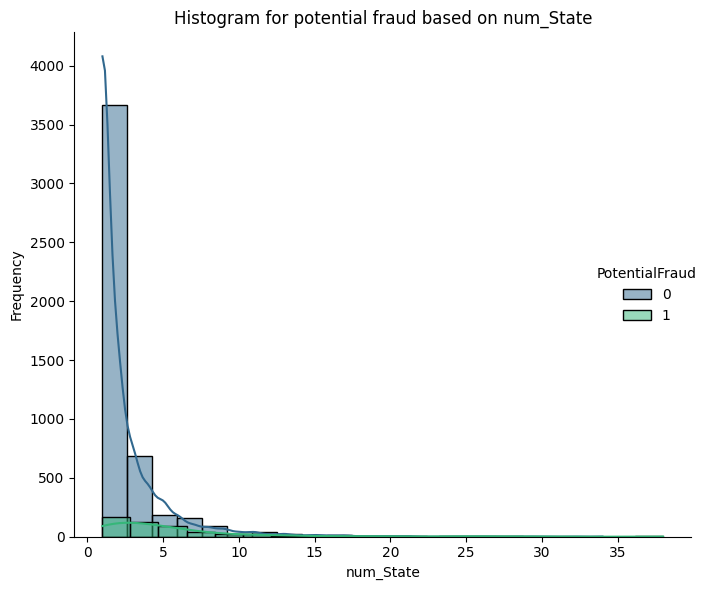

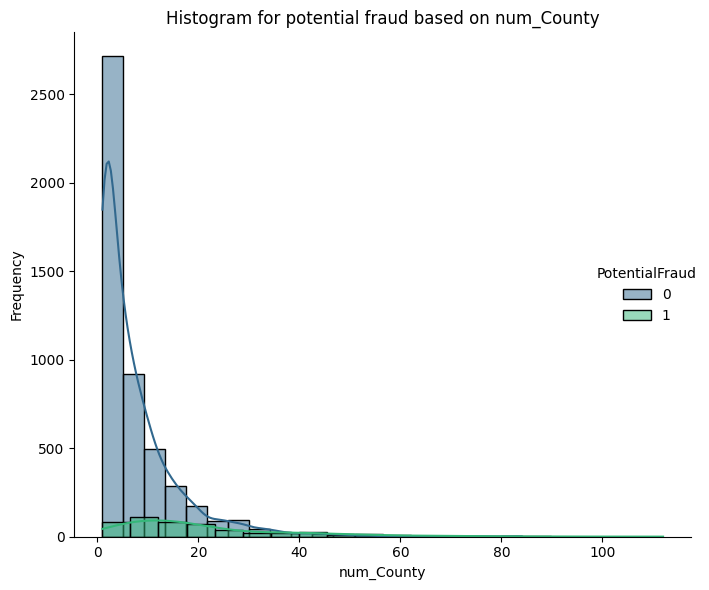

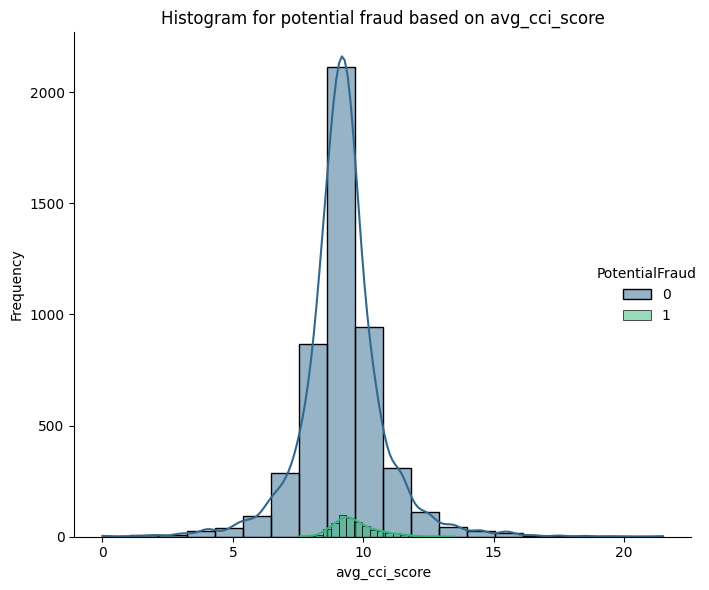

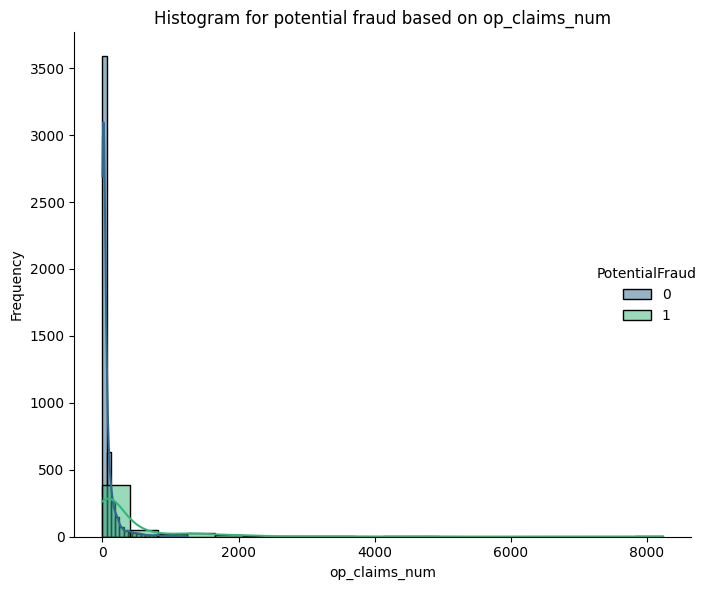

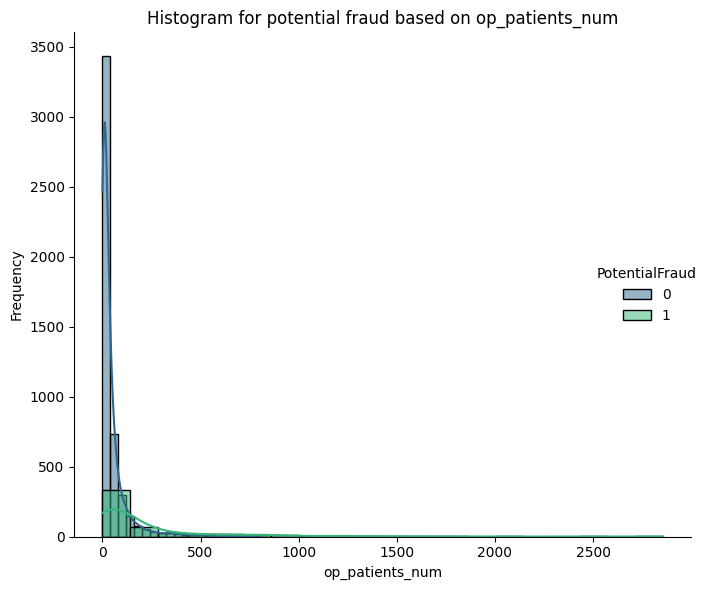

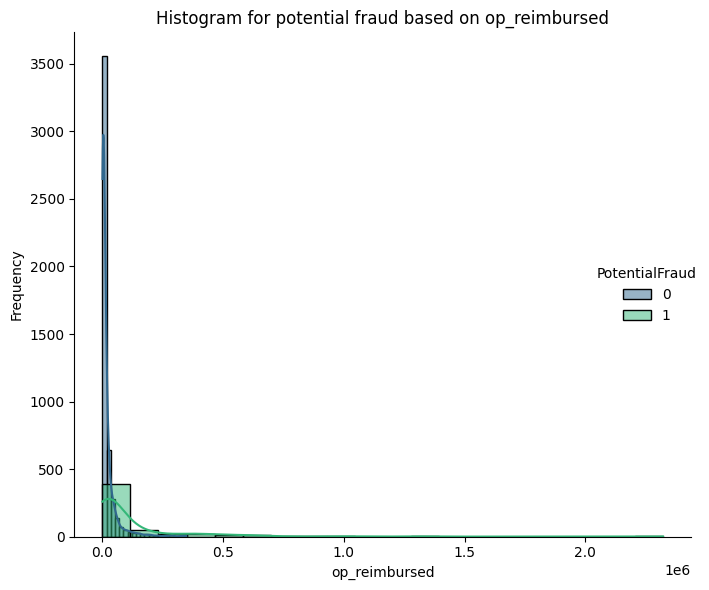

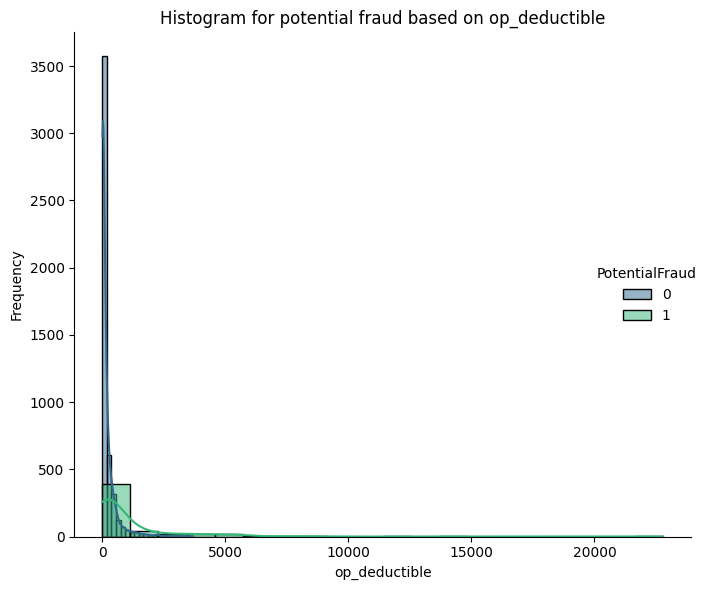

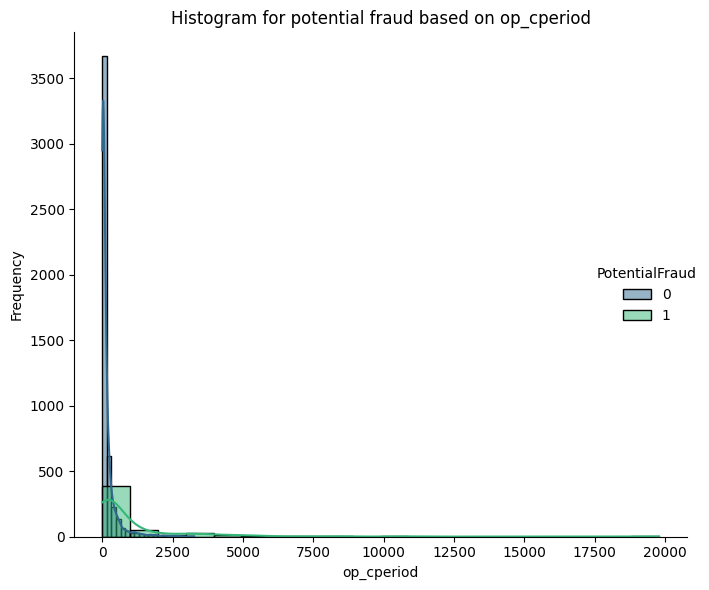

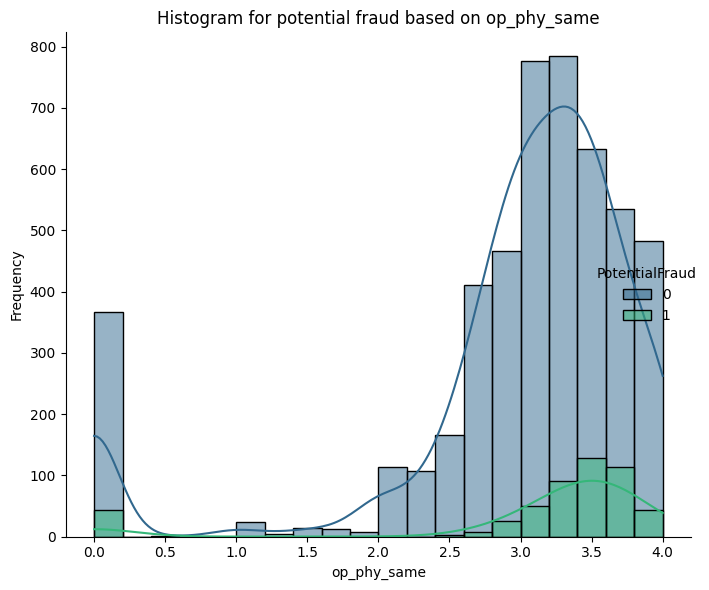

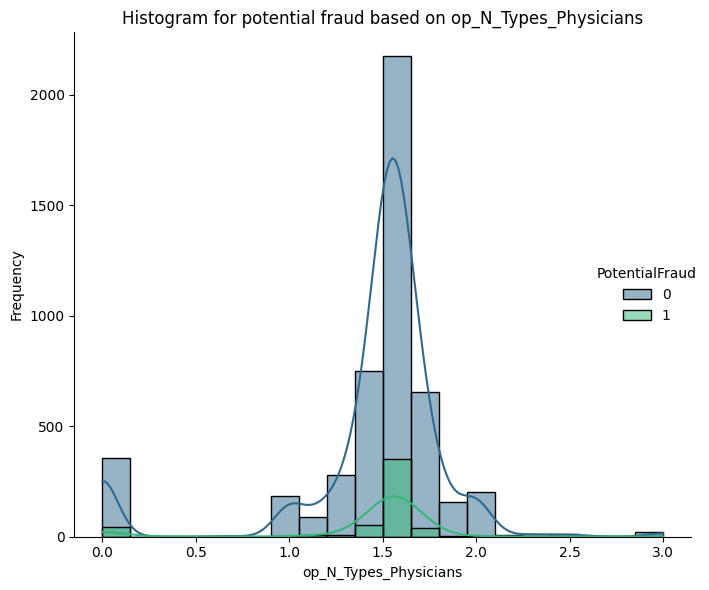

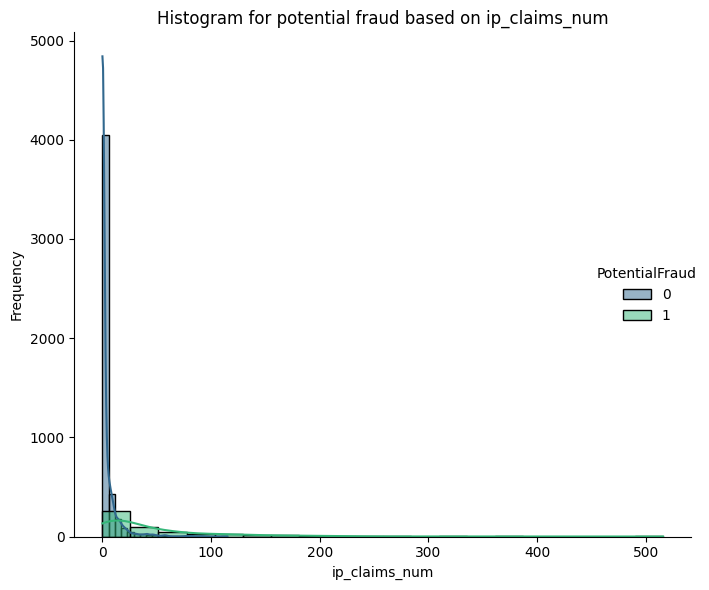

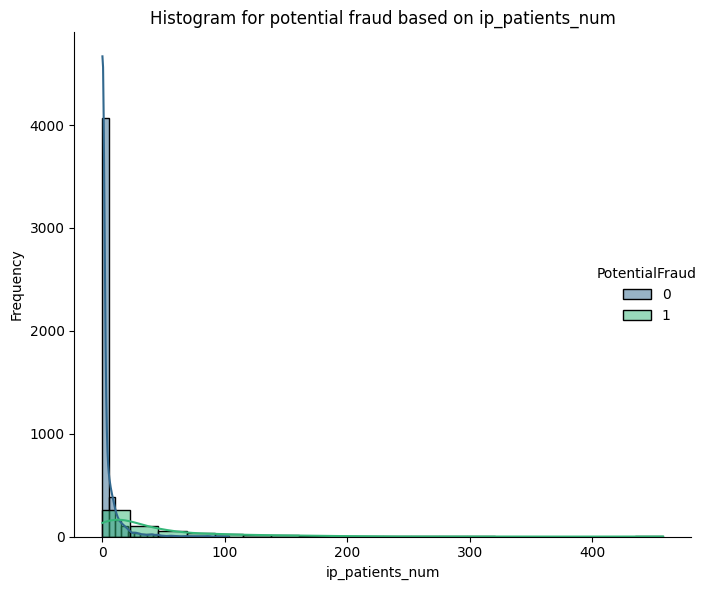

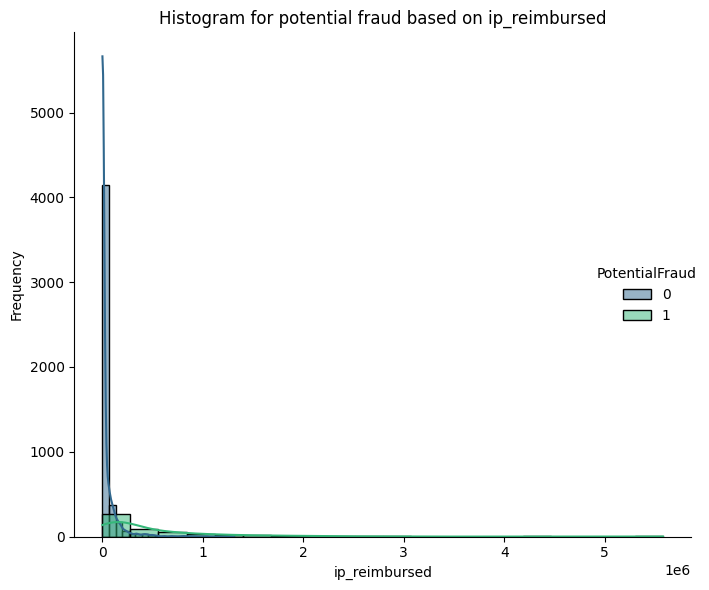

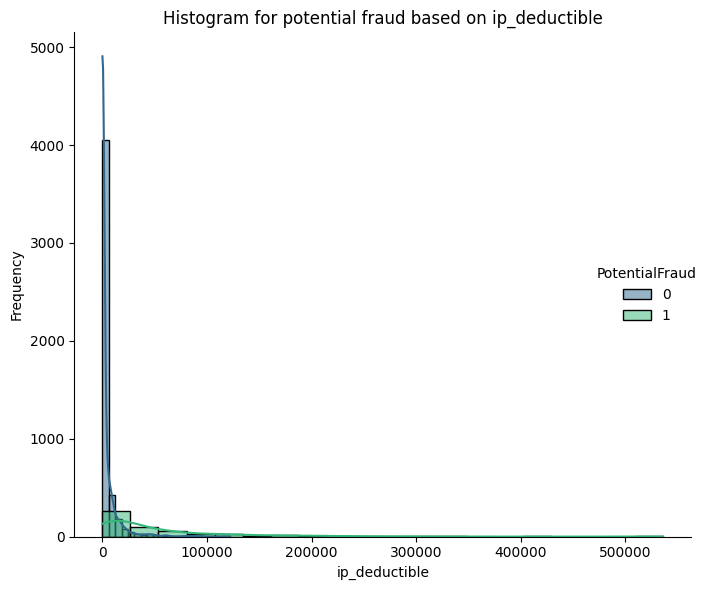

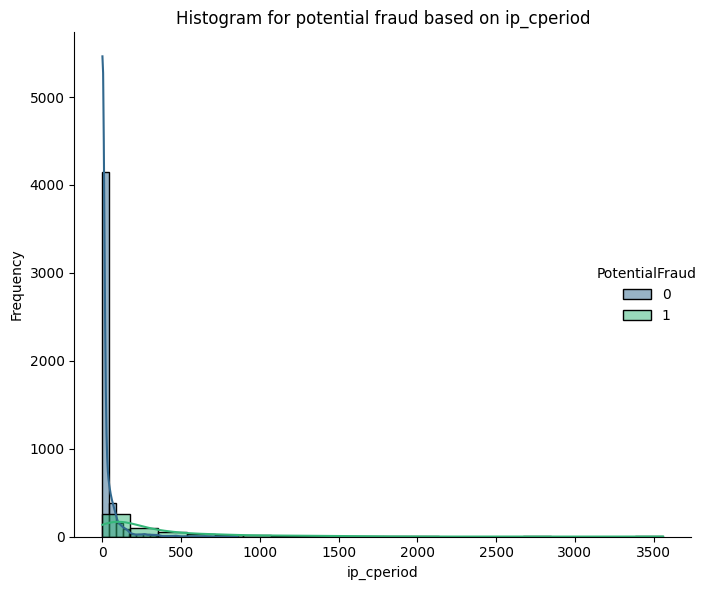

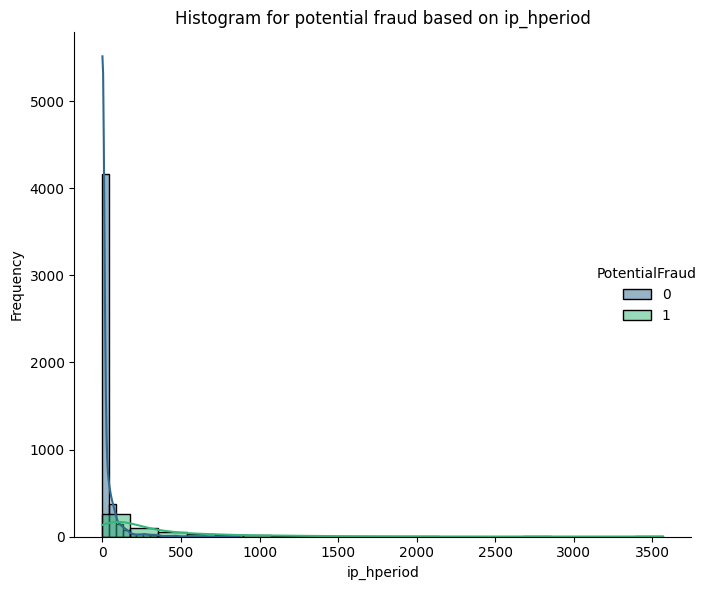

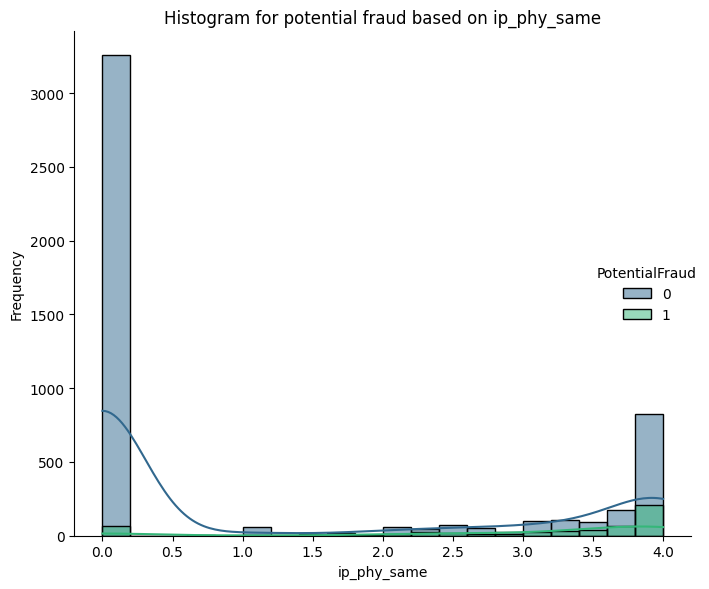

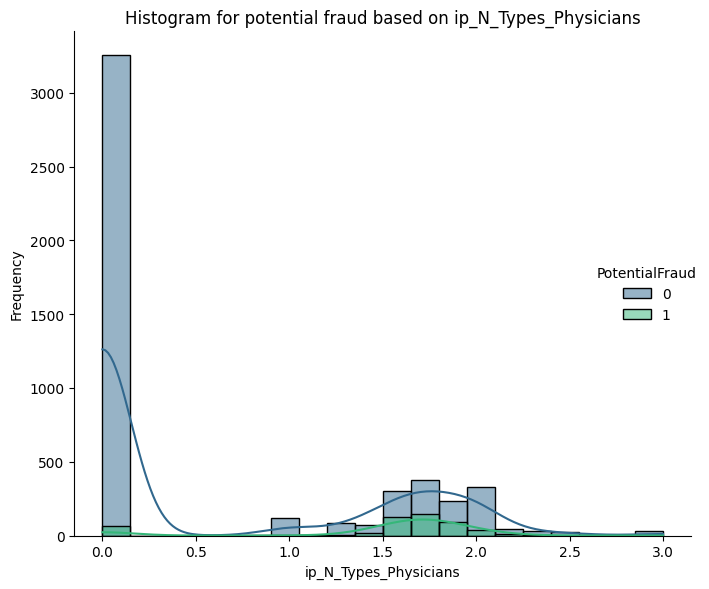

In [108]:
# Columns to normalize
columns_to_normalize = ['num_death_cases', 'avg_age', 'num_State', 'num_County',
        'avg_cci_score', 'op_claims_num', 'op_patients_num', 'op_reimbursed',
        'op_deductible', 'op_cperiod', 'op_phy_same', 'op_N_Types_Physicians',
        'ip_claims_num', 'ip_patients_num', 'ip_reimbursed', 'ip_deductible',
        'ip_cperiod', 'ip_hperiod', 'ip_phy_same', 'ip_N_Types_Physicians']

# Plot histograms for each numerical column
for column in columns_to_normalize:
    g = sns.FacetGrid(df_final, hue="PotentialFraud", height=6, palette='viridis')
    g.map(sns.histplot, column, kde=True, bins=20).add_legend()
    
    # Set the title and labels
    plt.title(f'Histogram for potential fraud based on {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

In [109]:
# # categoical columns: replace null with []
# cat_col = ['Top_5_ClmAdmitDiagnosisCode_op', 'Top_5_ClmDiagnosisCode_op', 'Top_5_ClmAdmitDiagnosisCode_ip', 'Top_5_DiagnosisGroupCode_ip', 'Top_5_ClmDiagnosisCode_ip', 'Top_5_ClmProcedureCode_ip']
# for col in cat_col:
#     df_final[col] = df_final[col].apply(lambda x: x if isinstance(x, list) else [])

In [110]:
# categoical columns: replace null with []
# Convert lists to values
# For simplicity, we will replace NaN with a placeholder value, e.g., -1

cat_col = ['Top_5_ClmAdmitDiagnosisCode_op', 'Top_5_ClmDiagnosisCode_op', 'Top_5_ClmAdmitDiagnosisCode_ip', 'Top_5_DiagnosisGroupCode_ip', 'Top_5_ClmDiagnosisCode_ip', 'Top_5_ClmProcedureCode_ip']
for col in cat_col:
    df_final[col] = df_final[col].apply(lambda x: x if isinstance(x, list) else [])
    df_final[col] = df_final[col].apply(lambda x: str(x[0]) if x else 'None')

In [111]:
df_final.isnull().mean()*100

Provider                          0.0
num_death_cases                   0.0
avg_age                           0.0
num_State                         0.0
num_County                        0.0
avg_cci_score                     0.0
op_claims_num                     0.0
op_patients_num                   0.0
op_reimbursed                     0.0
op_deductible                     0.0
op_cperiod                        0.0
op_phy_same                       0.0
op_N_Types_Physicians             0.0
Top_5_ClmAdmitDiagnosisCode_op    0.0
Top_5_ClmDiagnosisCode_op         0.0
ip_claims_num                     0.0
ip_patients_num                   0.0
ip_reimbursed                     0.0
ip_deductible                     0.0
ip_cperiod                        0.0
ip_hperiod                        0.0
ip_phy_same                       0.0
ip_N_Types_Physicians             0.0
Top_5_ClmAdmitDiagnosisCode_ip    0.0
Top_5_DiagnosisGroupCode_ip       0.0
Top_5_ClmDiagnosisCode_ip         0.0
Top_5_ClmPro

#### label encoding

In [112]:
# for col in cat_col:
#     # Flatten the list of diagnosis codes
#     all_codes = [code for sublist in df_final[col] for code in sublist]

#     # Initialize the LabelEncoder
#     label_encoder = LabelEncoder()
#     label_encoder.fit(all_codes)

#     # Apply label encoding to each diagnosis code in the DataFrame
#     df_final[col] = df_final[col].apply(lambda codes: label_encoder.transform(codes))


In [113]:
for col in cat_col:

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    df_final[col] = label_encoder.fit_transform(df_final[col])

In [114]:
df_final[cat_col]

,Top_5_ClmAdmitDiagnosisCode_op,Top_5_ClmDiagnosisCode_op,Top_5_ClmAdmitDiagnosisCode_ip,Top_5_DiagnosisGroupCode_ip,Top_5_ClmDiagnosisCode_ip,Top_5_ClmProcedureCode_ip
0,846,213,393,575,259,343
1,846,213,393,575,259,343
2,846,213,393,575,259,343
3,846,213,162,229,84,89
4,846,213,227,263,84,87
...,...,...,...,...,...,...
5405,763,118,384,131,75,73
5406,816,724,334,241,84,318
5407,255,213,393,575,259,343
5408,846,107,393,575,259,343


#### train,test split

In [115]:
y = df_final['PotentialFraud']
X = df_final.drop(['PotentialFraud', 'Provider'], axis=1)

In [116]:
X.columns

Index(['num_death_cases', 'avg_age', 'num_State', 'num_County',
       'avg_cci_score', 'op_claims_num', 'op_patients_num', 'op_reimbursed',
       'op_deductible', 'op_cperiod', 'op_phy_same', 'op_N_Types_Physicians',
       'Top_5_ClmAdmitDiagnosisCode_op', 'Top_5_ClmDiagnosisCode_op',
       'ip_claims_num', 'ip_patients_num', 'ip_reimbursed', 'ip_deductible',
       'ip_cperiod', 'ip_hperiod', 'ip_phy_same', 'ip_N_Types_Physicians',
       'Top_5_ClmAdmitDiagnosisCode_ip', 'Top_5_DiagnosisGroupCode_ip',
       'Top_5_ClmDiagnosisCode_ip', 'Top_5_ClmProcedureCode_ip'],
      dtype='object')

<Axes: >

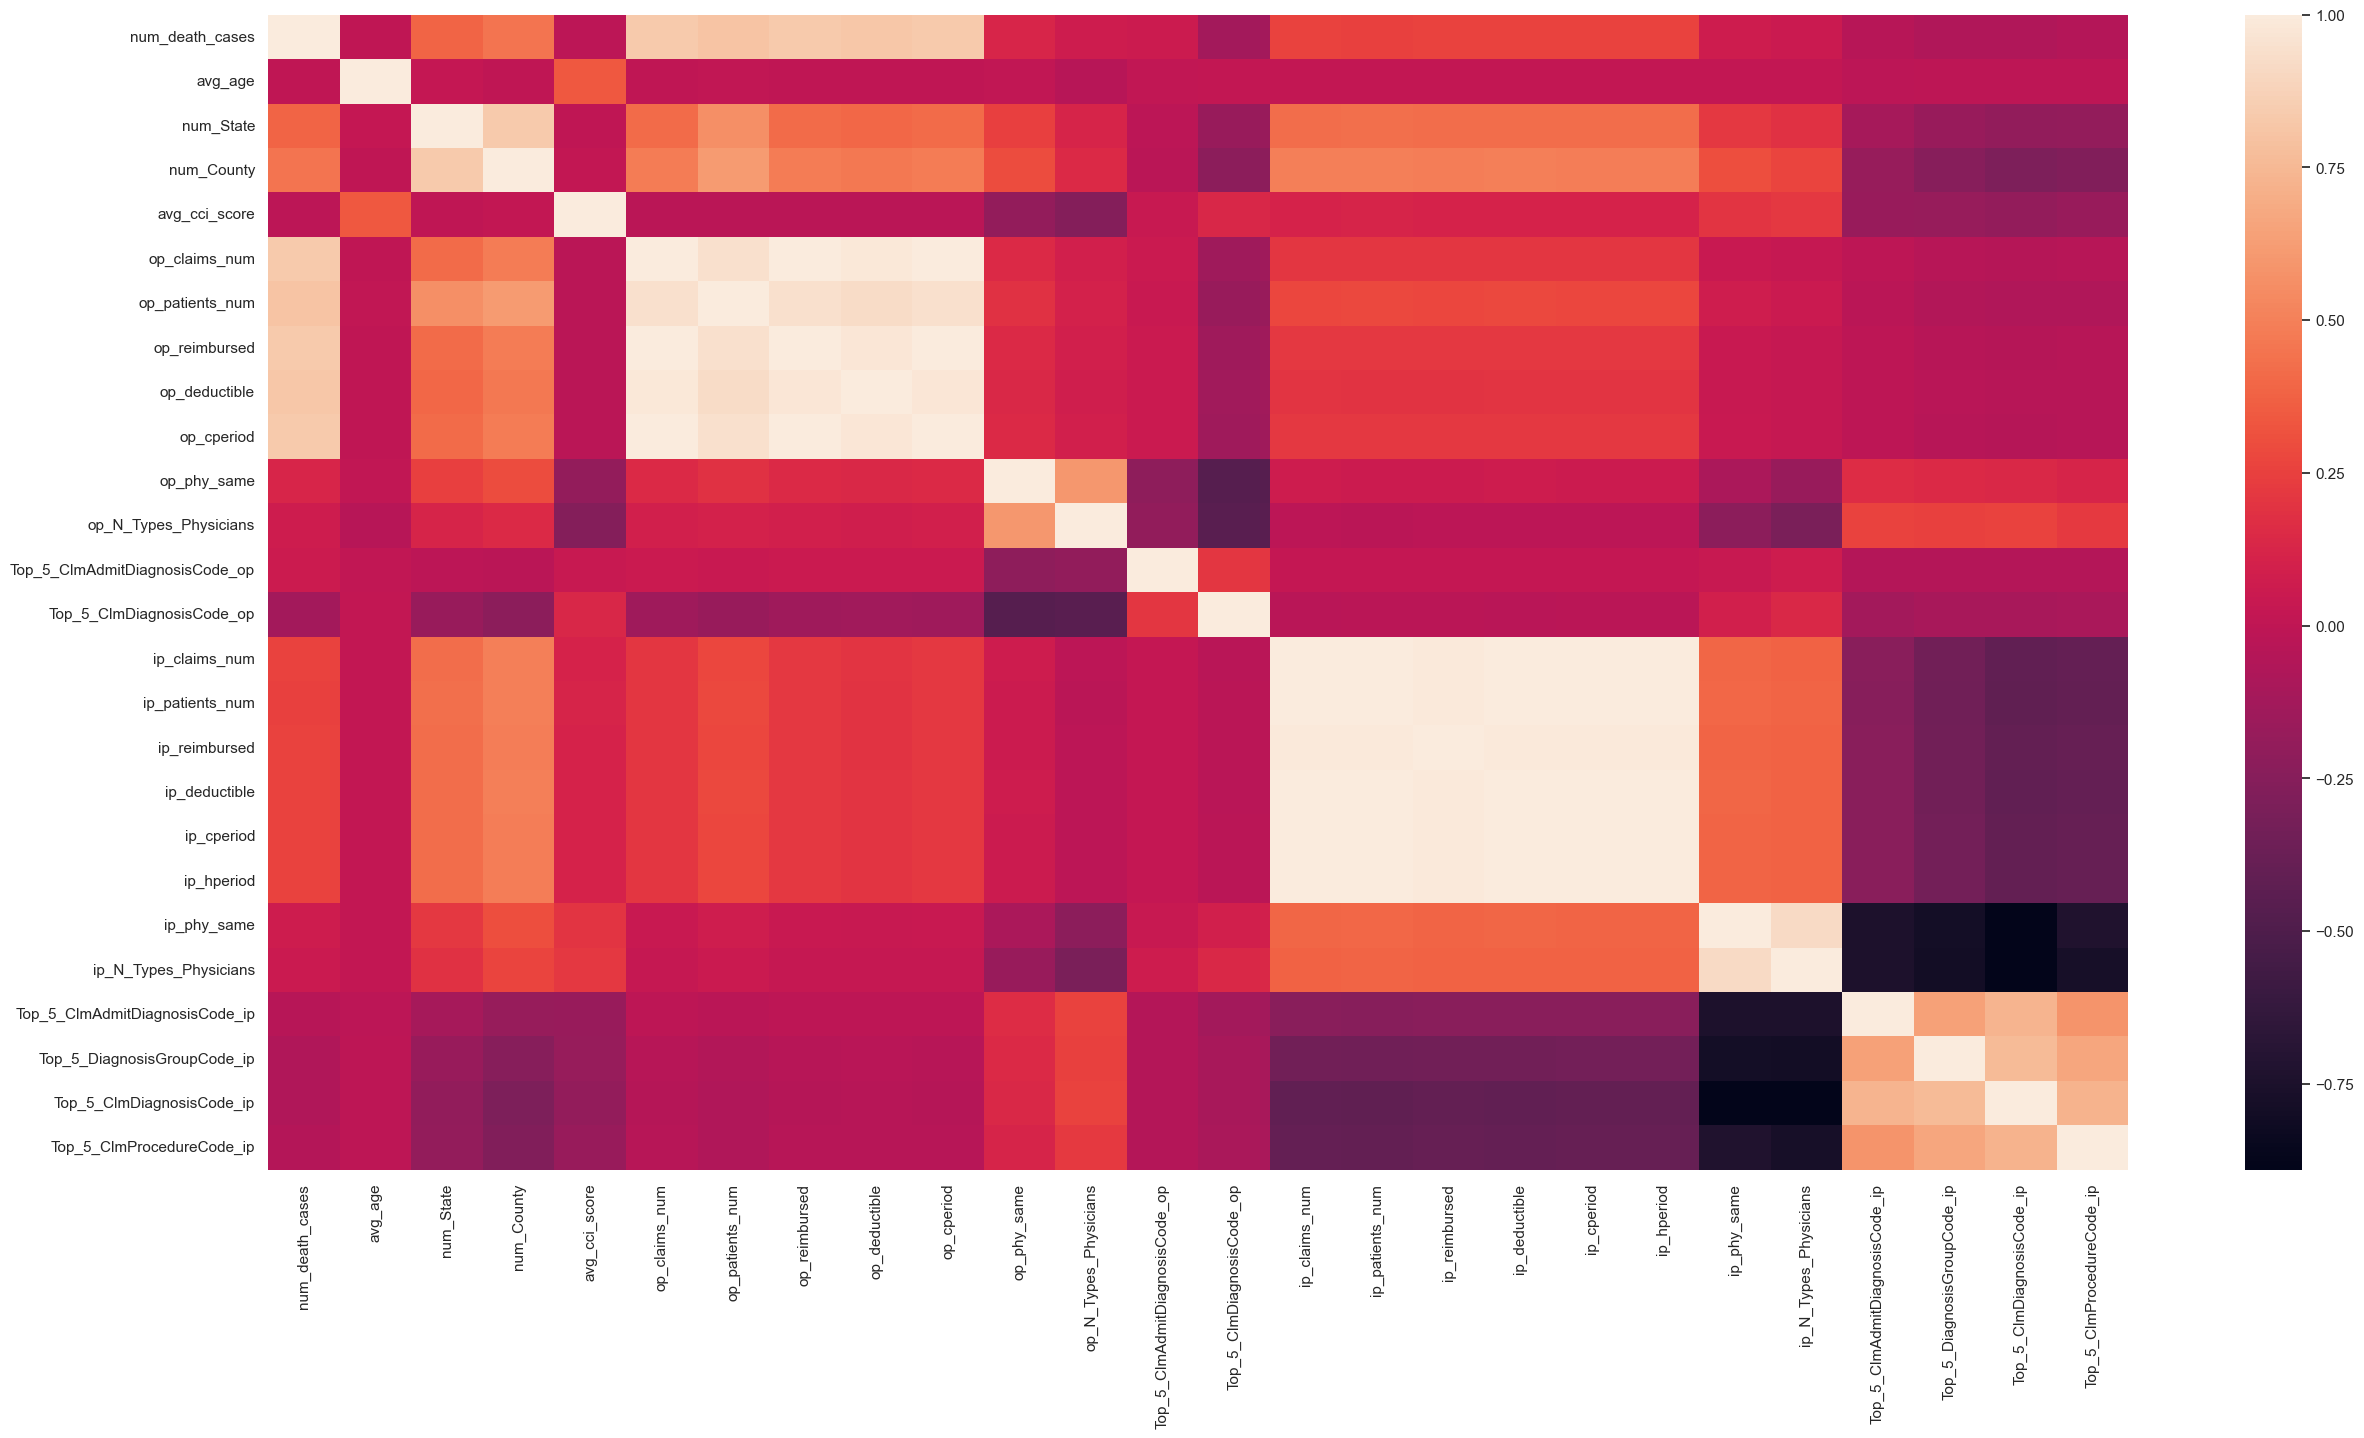

In [117]:
#plot correlation heat map between features
sns.set(context='notebook', style='whitegrid')
plt.figure(figsize=(30, 15))
corr = X.corr()
sns.heatmap(corr, annot=False)

In [118]:
# split data into train, validation, test dataset
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

print("Training X : ",X_train.shape," | Training Y : ",y_train.shape)
print("Validation X : ",X_val.shape," | Validation Y : ",y_val.shape)
print("Test X : ",X_test.shape," | Test Y : ",y_test.shape)

Training X :  (3246, 26)  | Training Y :  (3246,)
Validation X :  (1082, 26)  | Validation Y :  (1082,)
Test X :  (1082, 26)  | Test Y :  (1082,)


In [119]:
y_train.value_counts()

PotentialFraud
0    2952
1     294
Name: count, dtype: int64

#### normalization

KeyError: "None of [Index([('num_death_cases', 'avg_age', 'num_State', 'num_County', 'avg_cci_score', 'op_claims_num', 'op_patients_num', 'op_reimbursed', 'op_deductible', 'op_cperiod', 'op_phy_same', 'op_N_Types_Physicians', 'Top_5_ClmAdmitDiagnosisCode_op', 'Top_5_ClmDiagnosisCode_op', 'ip_claims_num', 'ip_patients_num', 'ip_reimbursed', 'ip_deductible', 'ip_cperiod', 'ip_hperiod', 'ip_phy_same', 'ip_N_Types_Physicians', 'Top_5_ClmAdmitDiagnosisCode_ip', 'Top_5_DiagnosisGroupCode_ip', 'Top_5_ClmDiagnosisCode_ip', 'Top_5_ClmProcedureCode_ip', 'PotentialFraud')], dtype='object')] are in the [columns]"

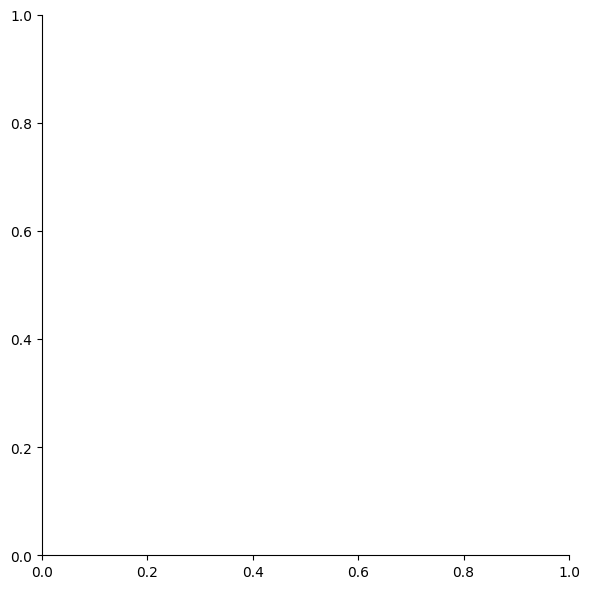

In [ ]:
# calculates and stores the parameters necessary for normalization based on the training data.
def num_col_normalizer(X_tr,X_va,X_te,col=''):
    """This function returns normalized column for train, validation, and test data"""
    normalizer = Normalizer()
    
    normalizer.fit(X_tr[col].values.reshape(-1,1))
    
    tr = normalizer.transform(X_tr[col].values.reshape(-1,1))
    va = normalizer.transform(X_va[col].values.reshape(-1,1))
    te = normalizer.transform(X_te[col].values.reshape(-1,1))
    
    return tr,va,te


# Normalize each column in train and test data
for col in tqdm_notebook(columns_to_normalize):
    tr, va, te = num_col_normalizer(X_train, X_val, X_test, col)
    X_train[col] = tr
    X_val[col] = va
    X_test[col] = te

### Modeling

#### Decision Tree

In [120]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights based on class frequencies
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

# Create a dictionary to map class labels to their weights
class_weight = {0: class_weights[0], 1: class_weights[1]}

print("Class weights:", class_weight)

Class weights: {0: 0.5497967479674797, 1: 5.520408163265306}


In [121]:
# Initialize the DecisionTreeClassifier with class_weight parameter
DT_model = DecisionTreeClassifier(class_weight=class_weight)

parameters = {'max_depth': [3, 5, 7, 10, 15]
              , 'min_samples_split': [5, 10, 20, 45, 75, 100, 135, 270, 500]
              , 'criterion': ['gini', 'entropy']
            #   , 'min_samples_leaf': [1, 5, 10]
              # , 'max_features': [None, 'auto', 'sqrt', 'log2']
              }

DT_model_CV = GridSearchCV(DT_model, parameters, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
DT_model_CV = DT_model_CV.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",DT_model_CV.best_params_)
print("roc_auc :",DT_model_CV.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5; 1/90] START criterion=gini, max_depth=3, min_samples_split=5...........
[CV 3/5; 1/90] START criterion=gini, max_depth=3, min_samples_split=5...........
[CV 1/5; 1/90] END criterion=gini, max_depth=3, min_samples_split=5;, score=(train=0.934, test=0.921) total time=   0.0s
[CV 3/5; 1/90] END criterion=gini, max_depth=3, min_samples_split=5;, score=(train=0.934, test=0.916) total time=   0.0s
[CV 4/5; 1/90] START criterion=gini, max_depth=3, min_samples_split=5...........
[CV 4/5; 2/90] START criterion=gini, max_depth=3, min_samples_split=10..........
[CV 4/5; 1/90] END criterion=gini, max_depth=3, min_samples_split=5;, score=(train=0.936, test=0.899) total time=   0.0s
[CV 5/5; 2/90] START criterion=gini, max_depth=3, min_samples_split=10..........
[CV 4/5; 2/90] END criterion=gini, max_depth=3, min_samples_split=10;, score=(train=0.936, test=0.899) total time=   0.0s
[CV 1/5; 2/90] START criterion=gini, max_depth=3

In [122]:
# model with best hyperparameters:
DT_model2 = DecisionTreeClassifier(class_weight=class_weight, criterion =  'gini', max_depth = 7, min_samples_split = 270)
DT_model2=DT_model2.fit(X_train,y_train)

print("score",DT_model2.score(X_val,y_val))

score 0.865988909426987


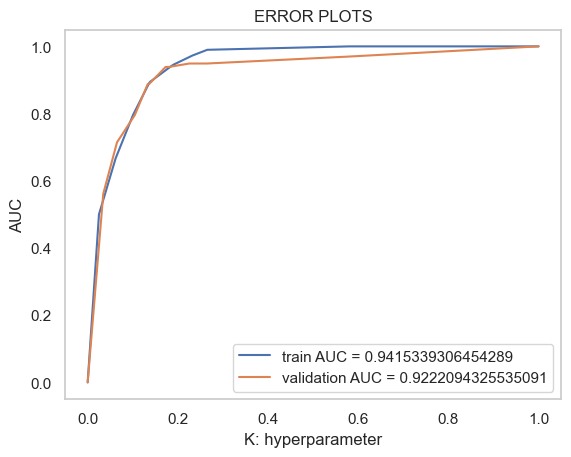

the maximum value of tpr*(1-fpr) 0.7706167155208967 for threshold 0.626
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      2952
           1       0.39      0.89      0.54       294

    accuracy                           0.86      3246
   macro avg       0.69      0.88      0.73      3246
weighted avg       0.93      0.86      0.89      3246

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       984
           1       0.39      0.89      0.55        98

    accuracy                           0.87      1082
   macro avg       0.69      0.88      0.73      1082
weighted avg       0.93      0.87      0.89      1082

Model validation Accuracy score is :  0.865988909426987
Model validation Recall score is :  0.8877551020408163
Model validation F1 score is :  0.5454545454545455
Model validation AUC score is :  0.9222094325535091


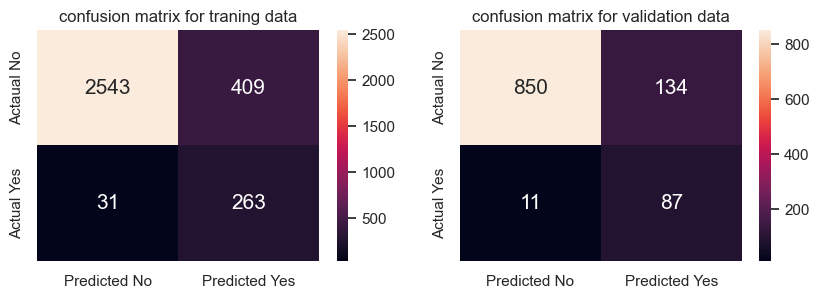

In [123]:
dt_model_accuracy_score, dt_model_recall_score, dt_model_f1_score, dt_model_AUC_score = model_performence_check(DT_model2,X_train,X_val,y_train,y_val)

#### Random Forest


In [126]:
RF = RandomForestClassifier(class_weight = class_weight, random_state=42)

param_grid = { 
    'n_estimators': [300, 500],
    # 'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7],
    'criterion' :['gini', 'entropy']
}


RF_CV = GridSearchCV(estimator=RF, param_grid=param_grid, cv= 5,scoring='roc_auc', n_jobs=-1, return_train_score=True, verbose=10)
RF_CV.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",RF_CV.best_params_)
print("roc_auc :",RF_CV.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 2/5; 1/16] START criterion=gini, max_depth=4, n_estimators=300..............
[CV 1/5; 1/16] START criterion=gini, max_depth=4, n_estimators=300..............
[CV 4/5; 1/16] START criterion=gini, max_depth=4, n_estimators=300..............
[CV 3/5; 1/16] START criterion=gini, max_depth=4, n_estimators=300..............
[CV 5/5; 1/16] START criterion=gini, max_depth=4, n_estimators=300..............
[CV 1/5; 2/16] START criterion=gini, max_depth=4, n_estimators=500..............
[CV 2/5; 2/16] START criterion=gini, max_depth=4, n_estimators=500..............
[CV 3/5; 2/16] START criterion=gini, max_depth=4, n_estimators=500..............
[CV 4/5; 1/16] END criterion=gini, max_depth=4, n_estimators=300;, score=(train=0.960, test=0.935) total time=   0.7s
[CV 4/5; 2/16] START criterion=gini, max_depth=4, n_estimators=500..............
[CV 1/5; 1/16] END criterion=gini, max_depth=4, n_estimators=300;, score=(train=0.958, test=

In [127]:
RF2 = RandomForestClassifier(n_estimators = 300,max_depth=4,criterion='entropy',
                             class_weight = class_weight, random_state=42
                             )

RF2=RF2.fit(X_train,y_train)

print("score",RF2.score(X_val,y_val))

score 0.8752310536044362


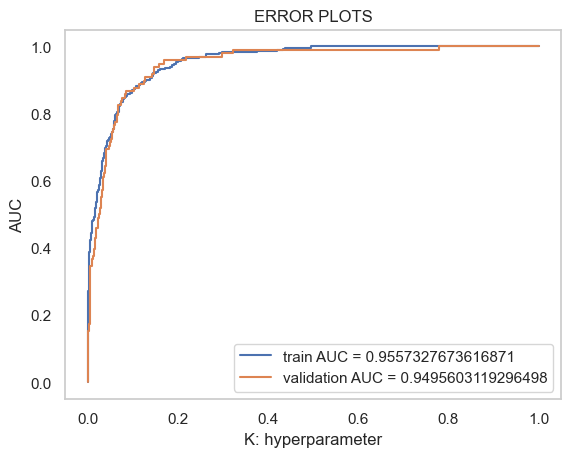

the maximum value of tpr*(1-fpr) 0.7878124827166639 for threshold 0.503
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      2952
           1       0.39      0.92      0.55       294

    accuracy                           0.86      3246
   macro avg       0.69      0.89      0.73      3246
weighted avg       0.94      0.86      0.88      3246

              precision    recall  f1-score   support

           0       0.99      0.87      0.93       984
           1       0.42      0.91      0.57        98

    accuracy                           0.88      1082
   macro avg       0.70      0.89      0.75      1082
weighted avg       0.94      0.88      0.90      1082

Model validation Accuracy score is :  0.8761552680221811
Model validation Recall score is :  0.9081632653061225
Model validation F1 score is :  0.5705128205128205
Model validation AUC score is :  0.9495603119296498


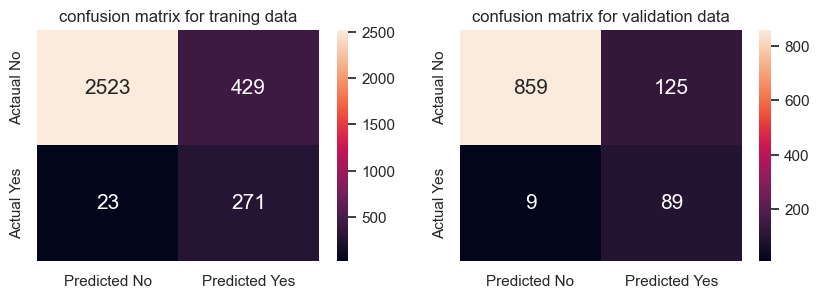

In [128]:
rf_model_accuracy_score, rf_model_recall_score, rf_model_f1_score, rf_model_AUC_score = model_performence_check(RF2,X_train,X_val,y_train,y_val)

#### XG_Boost

In [130]:
XGB = xgb.XGBClassifier()

parameters = {"eta" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] , "n_estimators" : [5,10,50, 75, 100]}

XGB_CV = RandomizedSearchCV(XGB, parameters , cv=5, scoring='roc_auc', n_jobs=-1,return_train_score=True, verbose=10)
XGB_CV.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",XGB_CV.best_params_)
print("roc_auc :",XGB_CV.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START eta=0.3, n_estimators=75...................................
[CV 2/5; 1/10] START eta=0.3, n_estimators=75...................................
[CV 4/5; 1/10] START eta=0.3, n_estimators=75...................................
[CV 3/5; 1/10] START eta=0.3, n_estimators=75...................................
[CV 5/5; 1/10] START eta=0.3, n_estimators=75...................................
[CV 1/5; 2/10] START eta=0.2, n_estimators=10...................................
[CV 2/5; 2/10] START eta=0.2, n_estimators=10...................................
[CV 3/5; 2/10] START eta=0.2, n_estimators=10...................................
[CV 1/5; 2/10] END eta=0.2, n_estimators=10;, score=(train=0.991, test=0.925) total time=   0.1s
[CV 3/5; 2/10] END eta=0.2, n_estimators=10;, score=(train=0.987, test=0.933) total time=   0.1s
[CV 2/5; 2/10] END eta=0.2, n_estimators=10;, score=(train=0.987, test=0.911) total time=   0.1s


In [131]:
XGB2 = xgb.XGBClassifier(eta=0.1,n_estimators=50)

XGB2=XGB2.fit(X_train,y_train)

print("score",XGB2.score(X_val,y_val))

score 0.9325323475046211


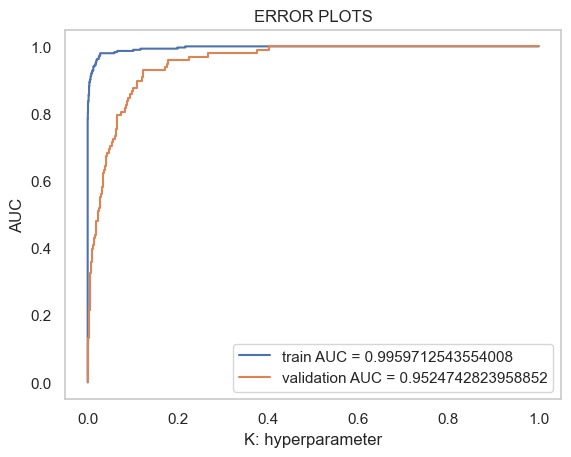

the maximum value of tpr*(1-fpr) 0.9523809523809523 for threshold 0.206
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2952
           1       0.78      0.98      0.87       294

    accuracy                           0.97      3246
   macro avg       0.89      0.98      0.93      3246
weighted avg       0.98      0.97      0.97      3246

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       984
           1       0.53      0.80      0.63        98

    accuracy                           0.92      1082
   macro avg       0.75      0.86      0.79      1082
weighted avg       0.94      0.92      0.92      1082

Model validation Accuracy score is :  0.9168207024029574
Model validation Recall score is :  0.7959183673469388
Model validation F1 score is :  0.6341463414634146
Model validation AUC score is :  0.9524742823958852


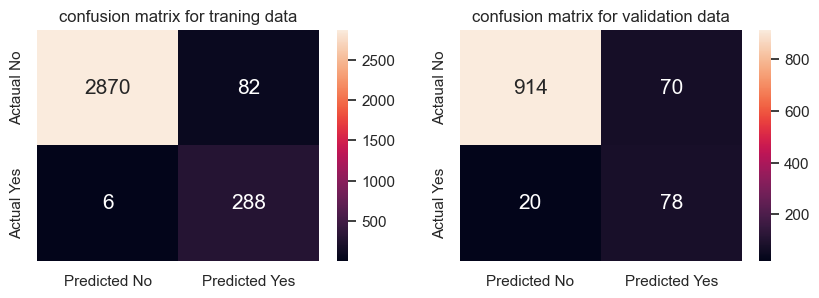

In [132]:
xg_model_accuracy_score, xg_model_recall_score, xg_model_f1_score, xg_model_AUC_score = model_performence_check(XGB2,X_train,X_val,y_train,y_val)